# **Predicting The Price of a House**

* In this kernel, we're going to use this kaggle dataset: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=train.csv <br>
to perform analysis and to predict housing prices.

## **Setting up**

In [111]:
# importing libraries

# ignoring warnings
import warnings 
warnings.filterwarnings("ignore")

# Data Analysis & Visualizations Libraries
import scipy
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Data Preprocessing and Traditional ML libraries
import sklearn
import sklearn_pandas
import xgboost
import lightgbm
import catboost

# Hyperparameter Optimization
import optuna

In [2]:
sns.set_theme()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

> **Note**: that we'll import the classes and functions of these libraries as we proceed ***
> This is just a general look on what we're going to use.

## **Inspecting The Data**

In [3]:
housing_df = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")
housing_df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL       65.000     8450   Pave   NaN      Reg   
1   2          20       RL       80.000     9600   Pave   NaN      Reg   
2   3          60       RL       68.000    11250   Pave   NaN      IR1   
3   4          70       RL       60.000     9550   Pave   NaN      IR1   
4   5          60       RL       84.000    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

We Have 81 Features with 1460 data samples

> **Note**: For more information on the data features please refer to the kaggle website.

looks like we have columns that contains a lot of nan values.
let's drop columns where their entries are more than 30% null values

In [5]:
null_percent = 0.3
nulls = ((housing_df.isna().sum() / housing_df.shape[0]) > null_percent).to_frame()
to_drop = nulls[nulls[0]].index.to_list()

* We need to drop the id, MoSold, YrSold columns as we're trying to focus on predicting the price with house feaures 

In [6]:
to_drop.extend(["Id", "MoSold", "YrSold", 'YearBuilt', 'YearRemodAdd'])
to_drop

['Alley',
 'FireplaceQu',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'Id',
 'MoSold',
 'YrSold',
 'YearBuilt',
 'YearRemodAdd']

In [7]:
housing_df.drop(to_drop, axis=1, inplace=True)
housing_df.shape

(1460, 71)

In [8]:
housing_df.duplicated().any()

False

No duplicates, Nice !

> Let's now split our Features to Categorical and Numerical

In [9]:
cat_features = list(housing_df.select_dtypes(include=['object']).columns)
num_features = list(housing_df.select_dtypes(include=['int64', 'float64']).columns)

In [10]:
housing_df[cat_features[:20]].describe()

MSZoning Street LotShape LandContour Utilities LotConfig LandSlope  \
count      1460   1460     1460        1460      1460      1460      1460   
unique        5      2        4           4         2         5         3   
top          RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
freq       1151   1454      925        1311      1459      1052      1382   

       Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle  \
count          1460       1460       1460     1460       1460      1460   
unique           25          9          8        5          8         6   
top           NAmes       Norm       Norm     1Fam     1Story     Gable   
freq            225       1260       1445     1220        726      1141   

       RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual ExterCond  \
count      1460        1460        1460       1452      1460      1460   
unique        8          15          16          4         4         5   
top     CompShg     VinylSd     VinylSd       None        TA        TA   
freq       1434         515         504        864       906      1282   

       Foundation  
count        1460  
unique          6  
top         PConc  
freq          647

In [11]:
housing_df[cat_features[20:]].describe()

BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 Heating  \
count      1423     1423         1422         1423         1422    1460   
unique        4        4            4            6            6       6   
top          TA       TA           No          Unf          Unf    GasA   
freq        649     1311          953          430         1256    1428   

       HeatingQC CentralAir Electrical KitchenQual Functional GarageType  \
count       1460       1460       1459        1460       1460       1379   
unique         5          2          5           4          7          6   
top           Ex          Y      SBrkr          TA        Typ     Attchd   
freq         741       1365       1334         735       1360        870   

       GarageFinish GarageQual GarageCond PavedDrive SaleType SaleCondition  
count          1379       1379       1379       1460     1460          1460  
unique            3          5          5          3        9             6  
top             Unf         TA         TA          Y       WD        Normal  
freq            605       1311       1326       1340     1267          1198

no low or high cardinlity issues are found !
Though, there're columns that needs imputing

In [12]:
housing_df[num_features[:20]].describe()

MSSubClass  LotFrontage    LotArea  OverallQual  OverallCond  \
count    1460.000     1201.000   1460.000     1460.000     1460.000   
mean       56.897       70.050  10516.828        6.099        5.575   
std        42.301       24.285   9981.265        1.383        1.113   
min        20.000       21.000   1300.000        1.000        1.000   
25%        20.000       59.000   7553.500        5.000        5.000   
50%        50.000       69.000   9478.500        6.000        5.000   
75%        70.000       80.000  11601.500        7.000        6.000   
max       190.000      313.000 215245.000       10.000        9.000   

       MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
count    1452.000    1460.000    1460.000   1460.000     1460.000  1460.000   
mean      103.685     443.640      46.549    567.240     1057.429  1162.627   
std       181.066     456.098     161.319    441.867      438.705   386.588   
min         0.000       0.000       0.000      0.000        0.000   334.000   
25%         0.000       0.000       0.000    223.000      795.750   882.000   
50%         0.000     383.500       0.000    477.500      991.500  1087.000   
75%       166.000     712.250       0.000    808.000     1298.250  1391.250   
max      1600.000    5644.000    1474.000   2336.000     6110.000  4692.000   

       2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
count  1460.000      1460.000   1460.000      1460.000      1460.000   
mean    346.992         5.845   1515.464         0.425         0.058   
std     436.528        48.623    525.480         0.519         0.239   
min       0.000         0.000    334.000         0.000         0.000   
25%       0.000         0.000   1129.500         0.000         0.000   
50%       0.000         0.000   1464.000         0.000         0.000   
75%     728.000         0.000   1776.750         1.000         0.000   
max    2065.000       572.000   5642.000         3.000         2.000   

       FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  
count  1460.000  1460.000      1460.000      1460.000  
mean      1.565     0.383         2.866         1.047  
std       0.551     0.503         0.816         0.220  
min       0.000     0.000         0.000         0.000  
25%       1.000     0.000         2.000         1.000  
50%       2.000     0.000         3.000         1.000  
75%       2.000     1.000         3.000         1.000  
max       3.000     2.000         8.000         3.000

In [13]:
housing_df[num_features[20:]].describe()

TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  \
count      1460.000    1460.000     1379.000    1460.000    1460.000   
mean          6.518       0.613     1978.506       1.767     472.980   
std           1.625       0.645       24.690       0.747     213.805   
min           2.000       0.000     1900.000       0.000       0.000   
25%           5.000       0.000     1961.000       1.000     334.500   
50%           6.000       1.000     1980.000       2.000     480.000   
75%           7.000       1.000     2002.000       2.000     576.000   
max          14.000       3.000     2010.000       4.000    1418.000   

       WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
count    1460.000     1460.000       1460.000   1460.000     1460.000   
mean       94.245       46.660         21.954      3.410       15.061   
std       125.339       66.256         61.119     29.317       55.757   
min         0.000        0.000          0.000      0.000        0.000   
25%         0.000        0.000          0.000      0.000        0.000   
50%         0.000       25.000          0.000      0.000        0.000   
75%       168.000       68.000          0.000      0.000        0.000   
max       857.000      547.000        552.000    508.000      480.000   

       PoolArea   MiscVal  SalePrice  
count  1460.000  1460.000   1460.000  
mean      2.759    43.489 180921.196  
std      40.177   496.123  79442.503  
min       0.000     0.000  34900.000  
25%       0.000     0.000 129975.000  
50%       0.000     0.000 163000.000  
75%       0.000     0.000 214000.000  
max     738.000 15500.000 755000.000

* Some columns may have outliers so, trimming may prove useful.
* ranges are difference so, for distance-based algorithms we need to scale the data.

let's remove the "SalePrice" from the num_feature since it's the target and not a feature.

In [14]:
# Removing 'SalePrice' from the num_feature list
num_features.remove("SalePrice")

### **Handling Missings**

* we've already did a bit of null handling by dropping the columns that have more than 30% of null values. However, there are still some columns with nulls. <br>
* Let's examine these columns to see what would be the best approach to impute each of them

#### Categorical missings

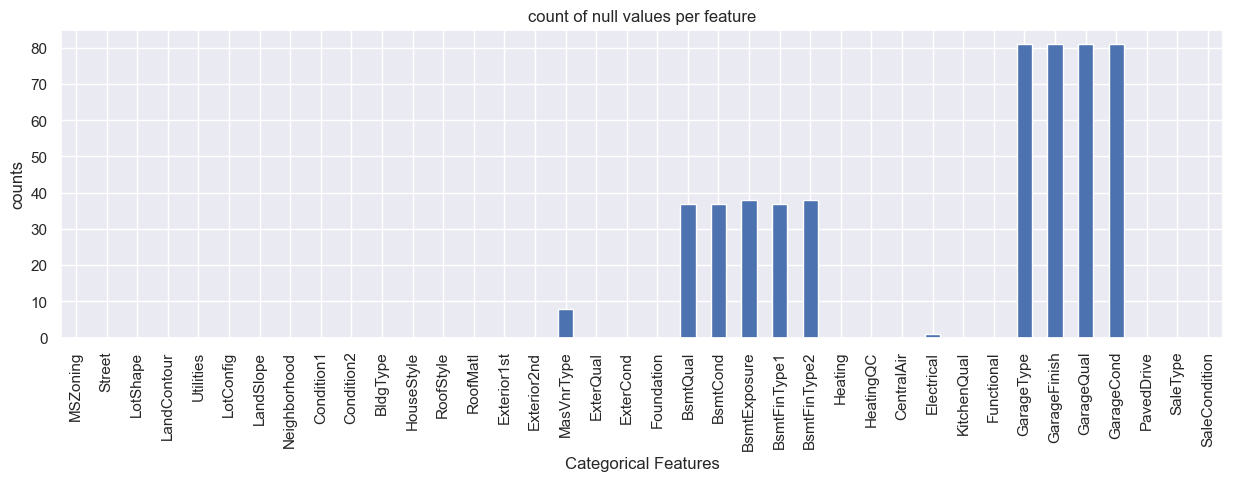

In [15]:
plt.figure(figsize=(15, 4))
categorical_missings = housing_df[cat_features].isna().sum()
categorical_missings.plot(kind="bar")
plt.xlabel("Categorical Features")
plt.ylabel("counts")
plt.title("count of null values per feature");

let's get those feature names

In [16]:
categorical_missings.name = "categorical_features"
categorical_missings = categorical_missings.to_frame()
cat_nulls = categorical_missings[categorical_missings["categorical_features"] > 0].index.to_list()
cat_nulls

['MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

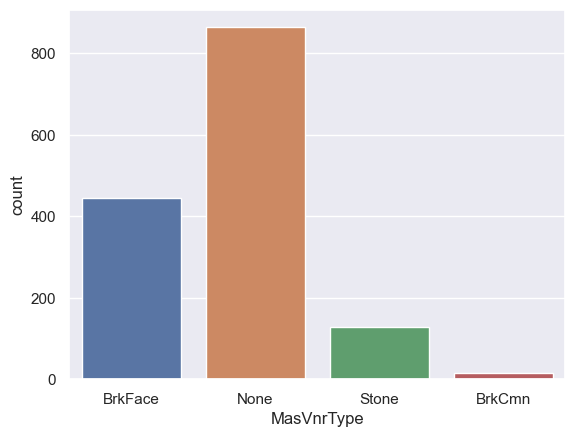

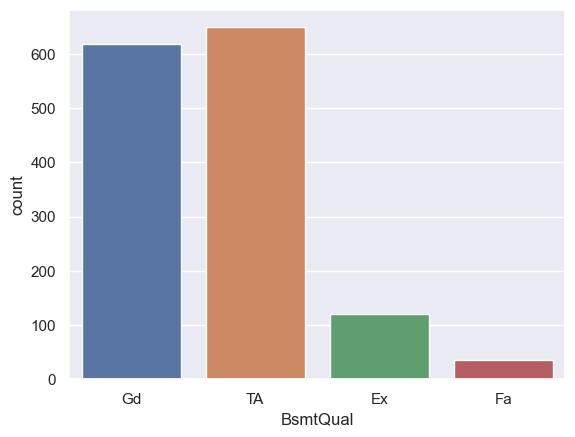

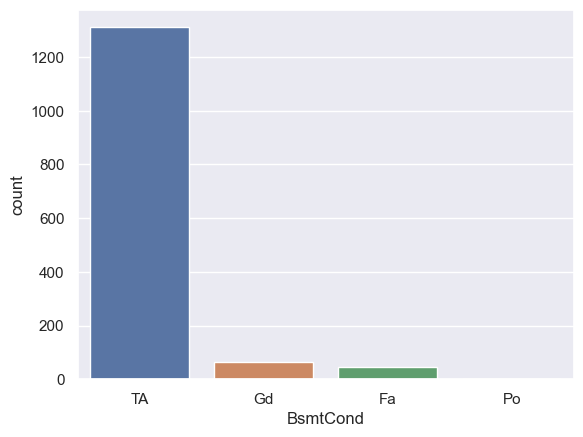

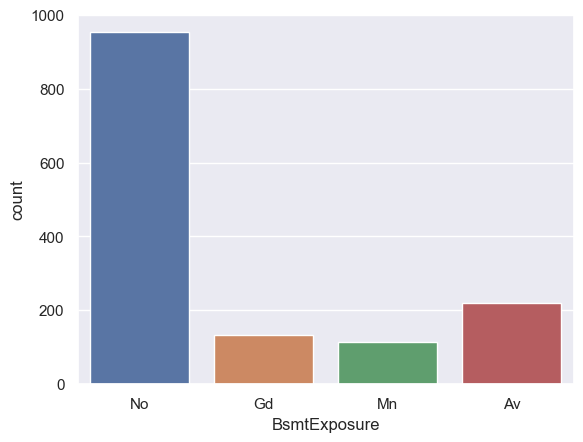

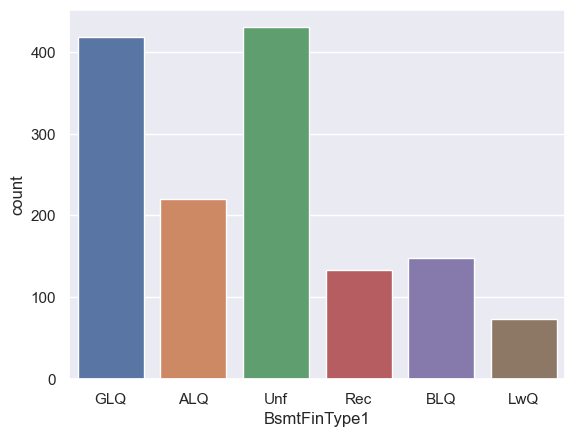

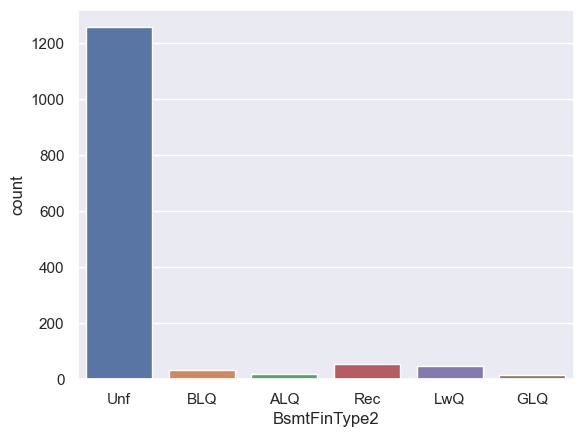

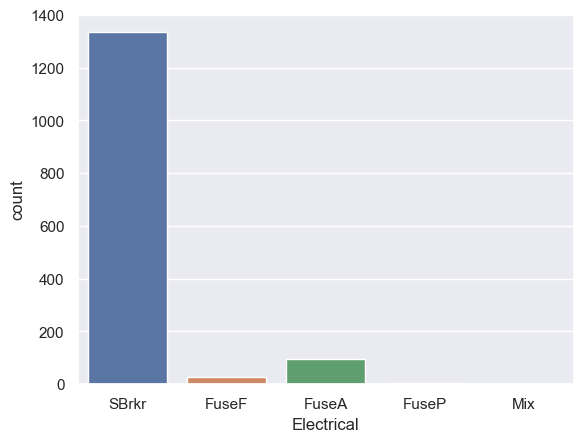

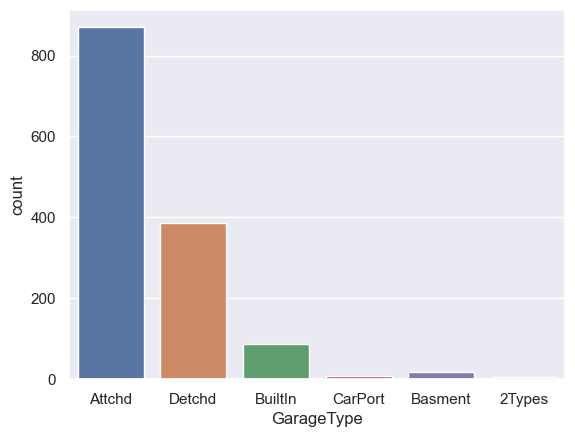

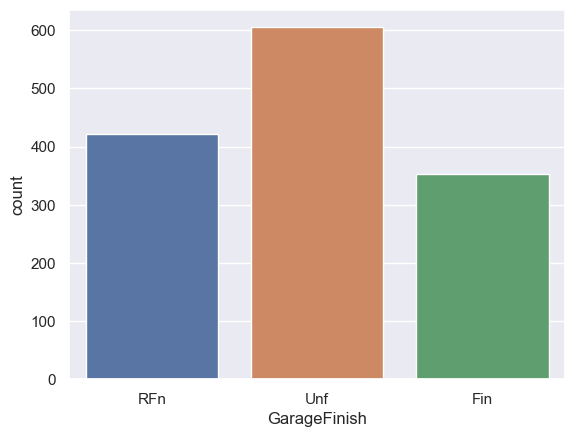

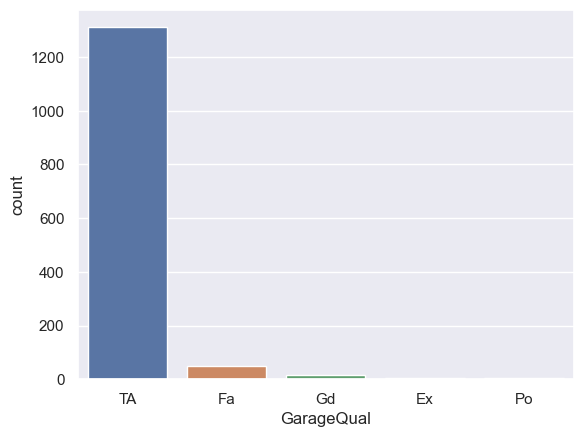

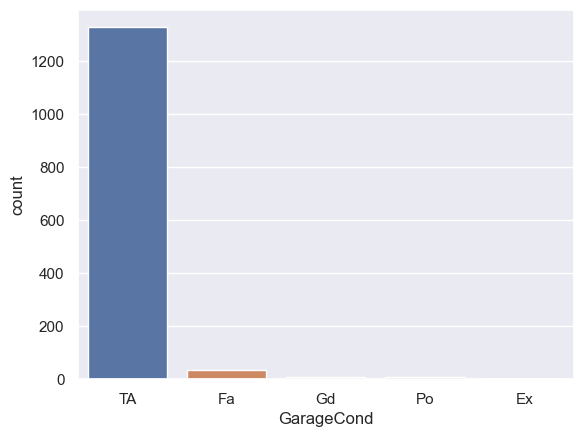

In [17]:
for col in cat_nulls:
    plt.figure()
    sns.countplot(data=housing_df, x=col)

Most of these features are dominated by one or two classes
A `SimpleImputer` with a strategy of "most frequent" is well enough for handling the missings in the categorical data

#### Numerical missings

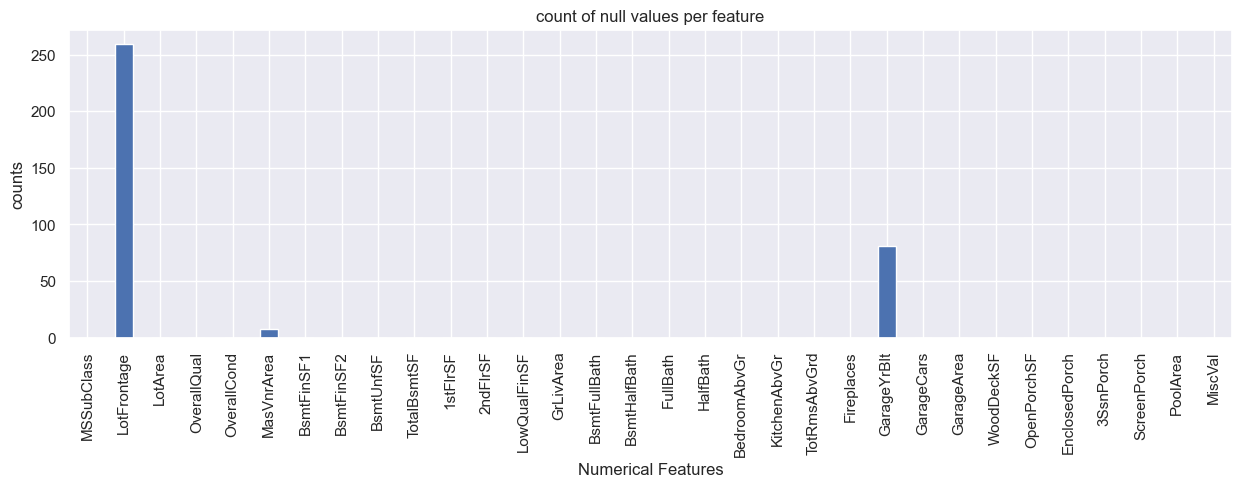

In [18]:
plt.figure(figsize=(15, 4))
numerical_missings = housing_df[num_features].isna().sum()
numerical_missings.plot(kind="bar")
plt.xlabel("Numerical Features")
plt.ylabel("counts")
plt.title("count of null values per feature");

In [19]:
numerical_missings.name = "numerical_features"
numerical_missings = numerical_missings.to_frame()
num_nulls = numerical_missings[numerical_missings["numerical_features"] > 0].index.to_list()
num_nulls

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

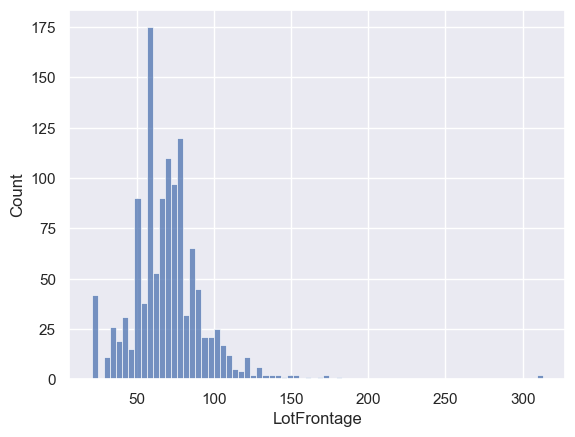

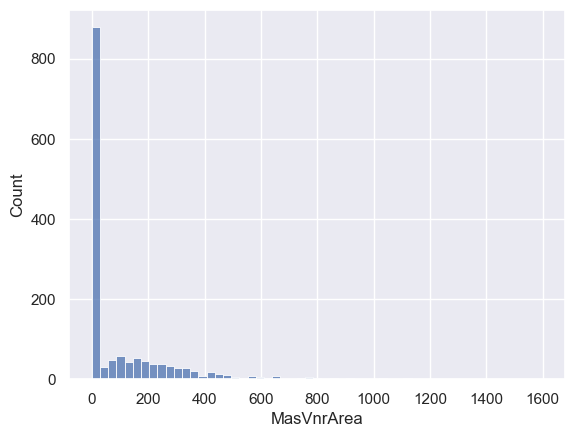

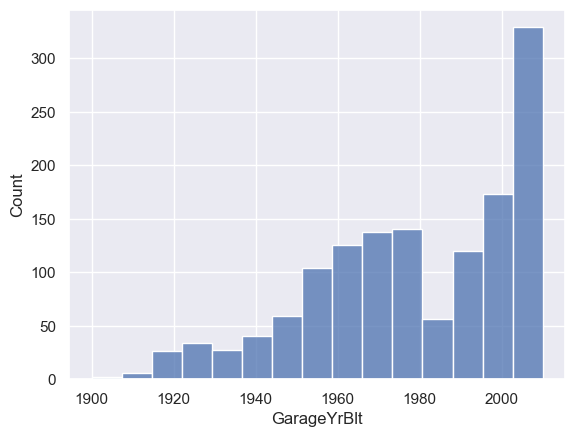

In [20]:
for col in num_nulls:
    plt.figure()
    sns.histplot(data=housing_df, x=col)

Looks like our missings in skewed numerical features
let's fill them using a `SimpleImputer` with the "median" as the strategy

### **Splitting the Data**
in this problem we'll use a train-validation-test split with 70%-15%-15%

In [21]:
from sklearn.model_selection import train_test_split

X = housing_df.drop("SalePrice", axis=1)
y = housing_df["SalePrice"]

X_train, X_test_vald, y_train, y_test_vald = train_test_split(X, y, train_size=0.7)
X_test, X_vald, y_test, y_vald = train_test_split(X_test_vald, y_test_vald, test_size=0.5)

X_train.shape, X_vald.shape, X_test.shape, y_train.shape, y_vald.shape, y_test.shape

((1021, 70), (220, 70), (219, 70), (1021,), (220,), (219,))

### **Imputing**

We're going to build a simple pipeline to impute the missings

In [22]:
# importing needed transformers
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [23]:
feature_names = num_features + cat_features

In [24]:
cat_imputer = SimpleImputer(strategy="most_frequent")
num_imputer = SimpleImputer(strategy="median")

imputer = ColumnTransformer(
    [
        ("num_imputer", num_imputer, num_features),
        ("cat_imputer", cat_imputer, cat_features),
        
    ],
    remainder="passthrough"
)

for now we'll just impute the training data so we can use it in determining the relevant features to perform EDA with them
and when we build the model we'll create a pipeline so we won't bother applying the same transformations on the validation and the testings datasets

In [25]:
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=feature_names)
X_train_imputed[num_features] = X_train_imputed[num_features].astype(np.float32)

In [26]:
X_train_imputed

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  MasVnrArea  \
0         20.000       60.000  7024.000        5.000        5.000       0.000   
1         20.000       69.000  8926.000        4.000        3.000       0.000   
2         60.000       69.000  7472.000        7.000        9.000     138.000   
3         20.000       70.000  8414.000        6.000        8.000       0.000   
4         20.000       69.000  8900.000        4.000        4.000       0.000   
...          ...          ...       ...          ...          ...         ...   
1016      60.000       52.000 46589.000        8.000        7.000     528.000   
1017      20.000       84.000 11670.000        9.000        5.000     302.000   
1018     120.000       43.000  3182.000        7.000        5.000      16.000   
1019      20.000      110.000 14226.000        8.000        5.000     375.000   
1020      20.000       69.000 11400.000       10.000        5.000     705.000   

      BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  ...  Electrical  \
0        980.000       0.000    110.000     1090.000  ...       SBrkr   
1          0.000       0.000    672.000      672.000  ...       FuseA   
2        626.000       0.000     99.000      725.000  ...       SBrkr   
3        663.000       0.000    396.000     1059.000  ...       SBrkr   
4       1056.000       0.000      0.000     1056.000  ...       SBrkr   
...          ...         ...        ...          ...  ...         ...   
1016    1361.000     180.000     88.000     1629.000  ...       SBrkr   
1017       0.000       0.000   1905.000     1905.000  ...       SBrkr   
1018      16.000       0.000   1357.000     1373.000  ...       SBrkr   
1019       0.000       0.000   1935.000     1935.000  ...       SBrkr   
1020    1282.000       0.000   1351.000     2633.000  ...       SBrkr   

      KitchenQual  Functional  GarageType  GarageFinish  GarageQual  \
0              TA         Typ      Attchd           Fin          TA   
1              TA         Typ     Basment           Unf          TA   
2              Gd         Typ      Attchd           Fin          TA   
3              TA         Typ      Attchd           RFn          TA   
4              TA         Typ      Detchd           Unf          TA   
...           ...         ...         ...           ...         ...   
1016           Gd         Typ      Attchd           RFn          TA   
1017           Ex         Typ      Attchd           Fin          TA   
1018           Gd         Typ      Attchd           Fin          TA   
1019           Gd         Typ      Attchd           Fin          TA   
1020           Ex         Typ      Attchd           RFn          TA   

      GarageCond  PavedDrive  SaleType  SaleCondition  
0             TA           Y        WD         Normal  
1             TA           Y       COD        Abnorml  
2             TA           Y        WD         Normal  
3             TA           Y        WD         Normal  
4             TA           Y        WD         Normal  
...          ...         ...       ...            ...  
1016          TA           Y        WD         Normal  
1017          TA           Y        WD         Normal  
1018          TA           Y        WD         Normal  
1019          TA           Y       New        Partial  
1020          TA           Y        WD         Normal  

[1021 rows x 70 columns]

### Feature Selection
Because our dataset contains both categorical and numerical features and since this a regression problem
We'll use two Feature selection techniques:

* **CFS** ~ with numerical feautres - to elimnate the redundant numerical features
* **ANOVA** ~ with categorical features - to select the the most effective categorical columns 


#### **CFS**

In [27]:
def CFS(X, threshold):
    """
    Correlation-based Feautre Selection
    searches for high-high features and exclude one of them

    args:
    - X
        pd.dataframe object that contains the x features.
    - threshold 
        the correlation threshold between the independent variables that if it exceeded
        one of columns will be dropped.

    returns:
        set of column names to drop from X 
    """
    col_corr = set() 
    corr_matrix = X.corr()
    for i in range(corr_matrix.shape[0]):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                col = corr_matrix.columns[i]
                col_corr.add(col)
    return col_corr

In [28]:
def CFST(X, y):
    """
    Correlation-based Feautre Selection with target
    searches for highly correlated features with target that have their correlation above their mean correlations

    args:
    - X
        pd.dataframe object that contains the numerical x features.
    - y 
        pd.series object that serves as the target for the dataset
        
    returns:
        set of column names to take from X 
    """
    correlations = []
    for col in X.columns:
        correlations.append(scipy.stats.pearsonr(X[col].values, y.values)[0])
        
    corr_series = pd.Series(np.abs(np.array(correlations)), index=X.columns).sort_values(ascending=False)    
    corr_series.name = "corrs"
    mean_corrs = corr_series.mean()
    corr_frame = corr_series.to_frame()
    features_above_mean =  corr_frame[corr_frame["corrs"] >= mean_corrs].index.to_list()
    print("RESULT: \n")
    print(f" ~ the mean correlation is", mean_corrs)
    
    plt.figure(figsize=(16, 8))
    graph = sns.barplot(y=corr_series.index, x=corr_series.values)    
    graph.axvline(mean_corrs)
    plt.xlabel("Absolute Correlation (Pearson)")
    plt.ylabel("Feature Name")
    plt.title("Correlation by feature")

    
    return mean_corrs, features_above_mean, corr_series

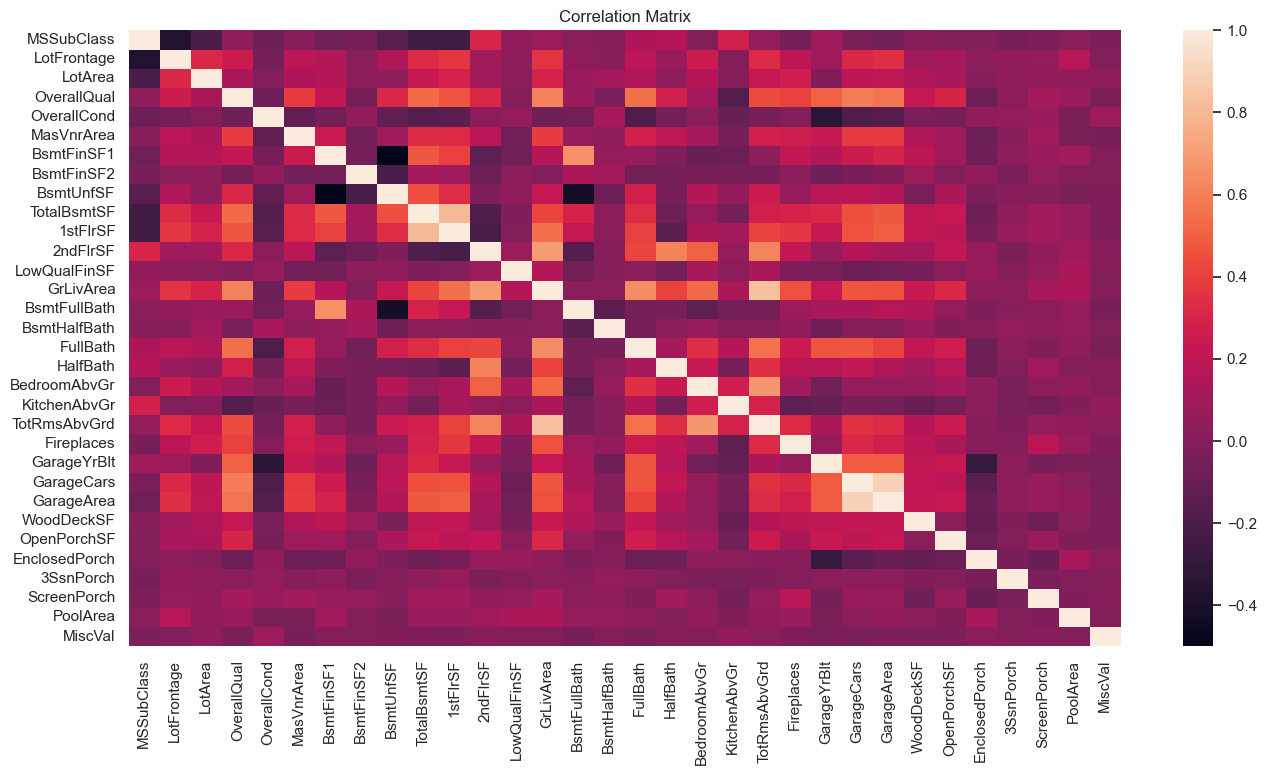

In [29]:
plt.figure(figsize=(16, 8))
sns.heatmap(X_train_imputed[num_features].corr())
plt.title("Correlation Matrix");

Looking at this matrix 
* the highest negative correlation is below 0.5
* most of the positive correlation columns are below 0.6

> this is great that we don't have redundencies in the data. However, because we have +30 columns of numerical data
let's remove some of the least useful columns

* we'll drop columns with correlation that's higher than 0.6 <br>
*dropping those columns will help reduce redundency while saving the same information as we only drop one of them*

In [30]:
# Columns to drop
high_high_features = list(CFS(X_train_imputed[num_features], threshold=0.60))
high_high_features

['TotRmsAbvGrd',
 'GrLivArea',
 'BsmtFullBath',
 'GarageArea',
 '1stFlrSF',
 'FullBath',
 'HalfBath']

In [31]:
non_redundant_num_features = list(set(num_features).difference(set(high_high_features)))

RESULT: 

 ~ the mean correlation is 0.26606157906867195


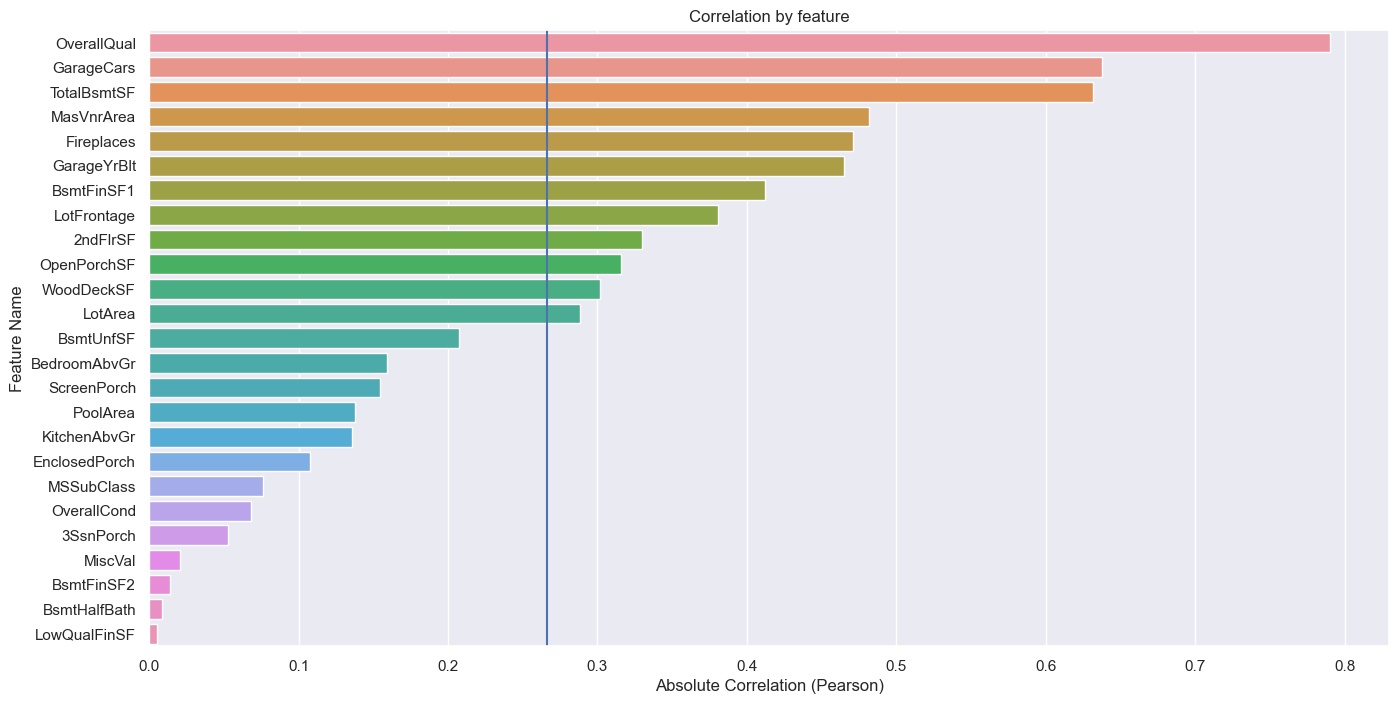

In [32]:
mean_corr, selected_num_features, corr_series = CFST(X_train_imputed[non_redundant_num_features], y_train)

In [33]:
selected_num_features

['OverallQual',
 'GarageCars',
 'TotalBsmtSF',
 'MasVnrArea',
 'Fireplaces',
 'GarageYrBlt',
 'BsmtFinSF1',
 'LotFrontage',
 '2ndFlrSF',
 'OpenPorchSF',
 'WoodDeckSF',
 'LotArea']

#### **ANOVA**

In [34]:
def ANOVA_regression(X, target, k, return_best_k=False, plot_graph=True):
    """
    ANOVA for Feature Selection.
    determines the importance of features based on f-scores.
    
    Note: 
    This function will work if your target is continuous -- Regression
    and feature X are all categorical features
    
    args:
    - X
        pd.dataframe or an array-like object that contains the x features.
    - target 
        pd.series or array-like object that contains the target feature.
    - k
        number of features to keep.
        
    returns:
        the best k feature names to use.
        plots The f-score for each of the feature.
    """
    
    from sklearn.feature_selection import f_classif
    f_scores = []
    for col in X.columns:
        f_score, p_value = f_classif(target.values.reshape(-1, 1), X[col])
        f_scores.append(f_score[0])
    feats = pd.Series(f_scores, index=X.columns).sort_values(ascending=False)
    
    if plot_graph:
        plt.figure(figsize=(16, 8))
        sns.barplot(x=feats.values, y=feats.index)
        plt.xlabel("F-SCORE")
        plt.ylabel("Feature Name")
        plt.title("F-SCORE by feature")

    kbest_names = feats.index[:k]
    if return_best_k:
        return list(kbest_names)

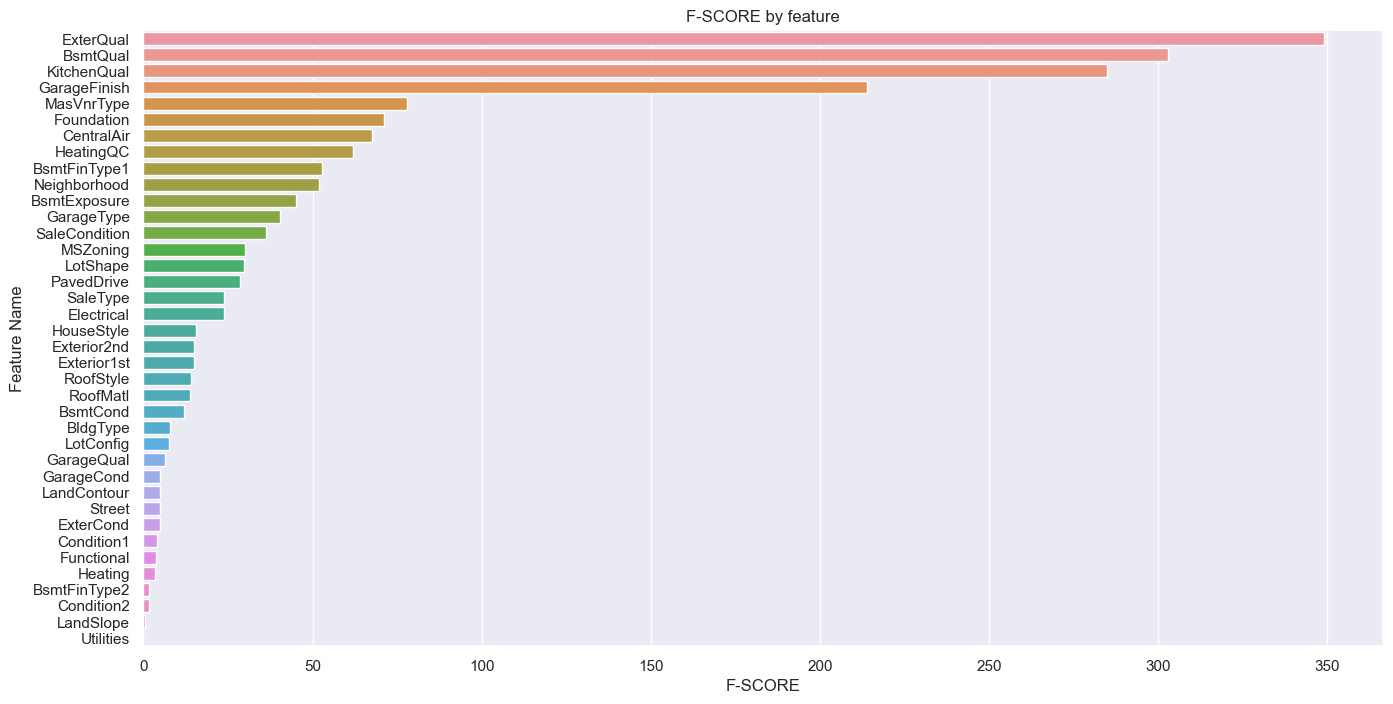

In [35]:
ANOVA_regression(X_train_imputed[cat_features], y_train, 10)

Looking at this graph we can segment our categorical features:

* High Features: from `ExterQual` to `GarageFinish`
* Mid-high Features: from `MasVnrType` to `BsmtExposure`
* Mid Features: from `GarageType` to `SaleType`
* Low Features: from `Electrical` to `Utilities`

We'll go with High and the Mid-high features only to reduce dimensionality

In [36]:
selected_cat_features = ANOVA_regression(X_train_imputed[cat_features], y_train, 11, plot_graph=False, return_best_k=True)
selected_cat_features

['ExterQual',
 'BsmtQual',
 'KitchenQual',
 'GarageFinish',
 'MasVnrType',
 'Foundation',
 'CentralAir',
 'HeatingQC',
 'BsmtFinType1',
 'Neighborhood',
 'BsmtExposure']

### **EDA**

Now we'll perform some Exploratory Data Analysis on the numerical and categorical Features we selected.
let's see if we can drop more features.

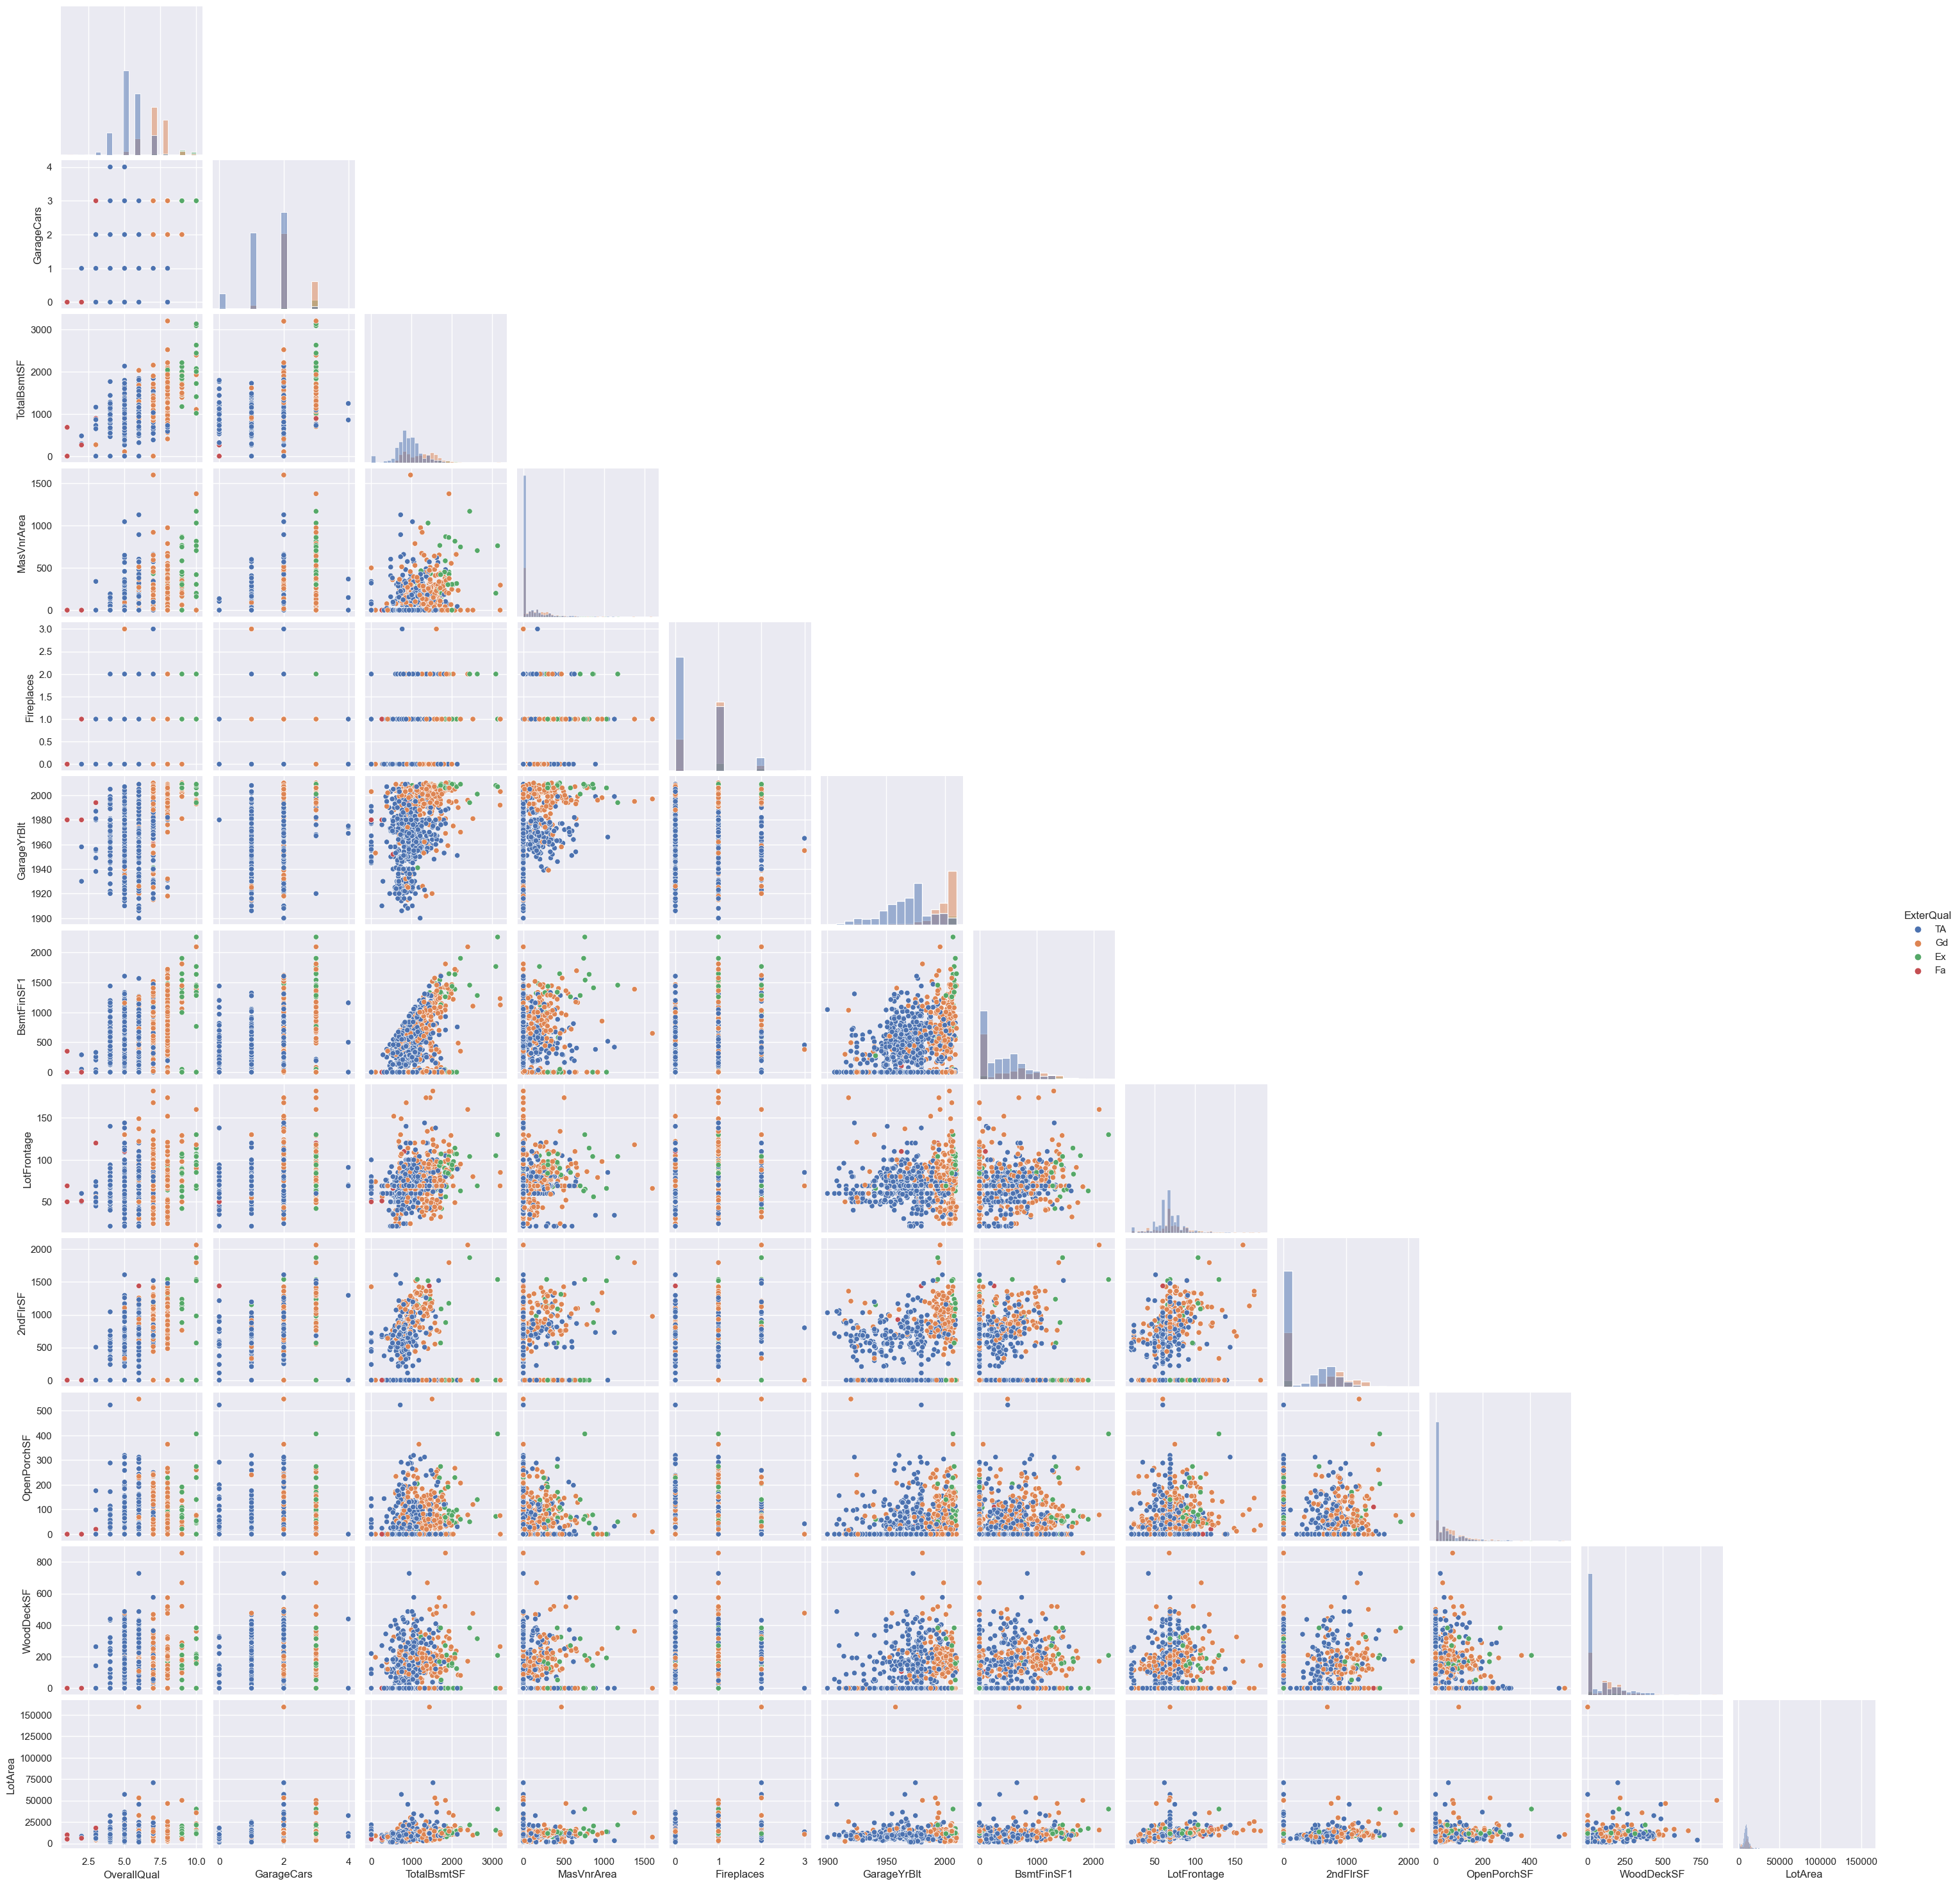

In [37]:
sns.pairplot(X_train_imputed[selected_num_features + ["ExterQual"]], corner=True, diag_kind="hist", hue="ExterQual")

Perfect!
Looks like we don't have any redundant numeric features, which is great!

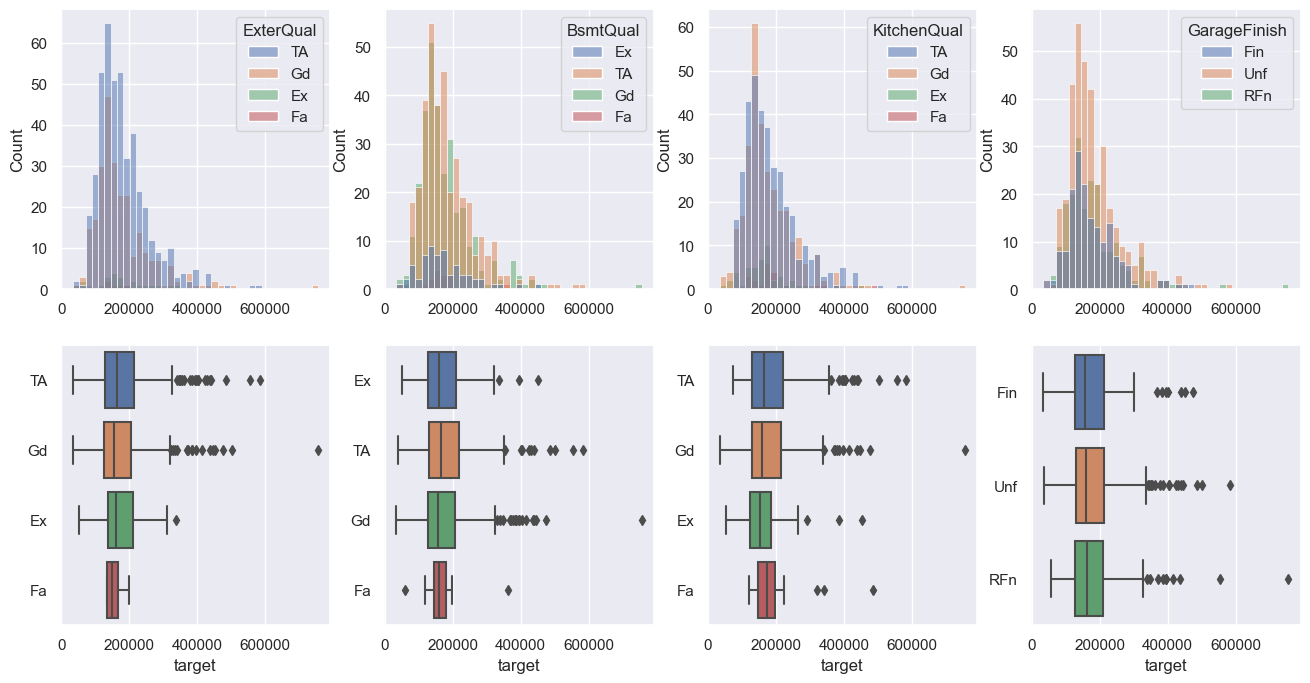

In [38]:
Mat = X_train_imputed[selected_cat_features[:4]].copy()
Mat["target"] = y_train
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
 
counter = 0
for col in selected_cat_features[:4]:
    sns.histplot(data=Mat, x="target", hue=col, ax=axes[0, counter])
    axes[0, counter].set(xlabel="")
    counter += 1
    
counter = 0
for col in selected_cat_features[:4]:
    sns.boxplot(data=Mat, x="target", y=col, ax=axes[1, counter])
    axes[1, counter].set(ylabel="")
    counter += 1    

### **Baseline Model**

For starters, we'll create a baseline model. We will have a ground on which we could compare our models.

In [39]:
# Baseline with the mean value
baseline_value = y_train.mean()
baseline_rmse = np.sum((y_train - baseline_value) ** 2) ** 0.5
print(f"The RMSE of the Baseline Model: {baseline_rmse}")

The RMSE of the Baseline Model: 2575077.021359273


#### **splitting fresh dataset**

so it has all the columns again and the missing values.

In [40]:
housing_df = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")
housing_df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL       65.000     8450   Pave   NaN      Reg   
1   2          20       RL       80.000     9600   Pave   NaN      Reg   
2   3          60       RL       68.000    11250   Pave   NaN      IR1   
3   4          70       RL       60.000     9550   Pave   NaN      IR1   
4   5          60       RL       84.000    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [41]:
X = housing_df.drop("SalePrice", axis=1)
y = housing_df["SalePrice"]

In [42]:
X_train, X_test_vald, y_train, y_test_vald = train_test_split(X, y, test_size=0.30, random_state=42)
X_test, X_vald, y_test, y_vald = train_test_split(X_test_vald, y_test_vald, test_size=0.5, random_state=42)

### **Modeling & Pipelining**

We'll Create a `Pipeline` that:
* Drops the unnecessary columns we dropped or we didn't select.
* Performs Imputing with the methods we selected.
* Performs OneHotEncoding/OrdinalEncoding - depends on the model we will use - with the selected categorical columns.
* Performs Scaling with the selected numerical columns. 
<br><br>
*and boom we have a pipeline ready!*

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn_pandas import DataFrameMapper, gen_features

In [44]:
excluded_num_features = list(set(num_features).difference(set(selected_num_features)))
excluded_cat_features = list(set(cat_features).difference(set(selected_cat_features)))

In [45]:
cat_trans = gen_features(
    columns=[[col] for col in selected_cat_features],
    classes=[{"class": SimpleImputer, "strategy": "most_frequent"}, OrdinalEncoder]
)
num_trans = gen_features(
    columns=[[col] for col in selected_num_features],
    classes=[{"class": SimpleImputer, "strategy": "median"}, MinMaxScaler]
)

In [46]:
num_trans + cat_trans

[(['OverallQual'], [SimpleImputer(strategy='median'), MinMaxScaler()], {}),
 (['GarageCars'], [SimpleImputer(strategy='median'), MinMaxScaler()], {}),
 (['TotalBsmtSF'], [SimpleImputer(strategy='median'), MinMaxScaler()], {}),
 (['MasVnrArea'], [SimpleImputer(strategy='median'), MinMaxScaler()], {}),
 (['Fireplaces'], [SimpleImputer(strategy='median'), MinMaxScaler()], {}),
 (['GarageYrBlt'], [SimpleImputer(strategy='median'), MinMaxScaler()], {}),
 (['BsmtFinSF1'], [SimpleImputer(strategy='median'), MinMaxScaler()], {}),
 (['LotFrontage'], [SimpleImputer(strategy='median'), MinMaxScaler()], {}),
 (['2ndFlrSF'], [SimpleImputer(strategy='median'), MinMaxScaler()], {}),
 (['OpenPorchSF'], [SimpleImputer(strategy='median'), MinMaxScaler()], {}),
 (['WoodDeckSF'], [SimpleImputer(strategy='median'), MinMaxScaler()], {}),
 (['LotArea'], [SimpleImputer(strategy='median'), MinMaxScaler()], {}),
 (['ExterQual'],
  [SimpleImputer(strategy='most_frequent'), OrdinalEncoder()],
  {}),
 (['BsmtQual'

In [47]:
Transformer = DataFrameMapper(
    num_trans + cat_trans,
    input_df=True,
    df_out=True
)

In [48]:
X_train[selected_num_features + selected_cat_features]

OverallQual  GarageCars  TotalBsmtSF  MasVnrArea  Fireplaces  \
135             7           2         1304     288.000           1   
1452            5           2          547      80.000           0   
762             7           2          756       0.000           0   
932             9           3         1905     302.000           1   
435             7           2          799       0.000           1   
...           ...         ...          ...         ...         ...   
1095            6           2         1314       0.000           1   
1130            4           2         1122       0.000           2   
1294            5           2          864       0.000           0   
860             7           1          912       0.000           1   
1126            7           3         1373     130.000           1   

      GarageYrBlt  BsmtFinSF1  LotFrontage  2ndFlrSF  OpenPorchSF  ...  \
135      1970.000           0       80.000         0            0  ...   
1452     2005.000         547       35.000         0           28  ...   
762      2009.000          24       72.000       783           45  ...   
932      2006.000           0       84.000         0          191  ...   
435      1996.000         385       43.000       834           61  ...   
...           ...         ...          ...       ...          ...  ...   
1095     2006.000          24       78.000         0           22  ...   
1130     1981.000         622       65.000       653           44  ...   
1294     1957.000         167       60.000         0            0  ...   
860      1925.000           0       55.000       514          240  ...   
1126     2007.000           0       53.000         0           20  ...   

      BsmtQual  KitchenQual GarageFinish MasVnrType Foundation CentralAir  \
135         TA           TA          Unf    BrkFace      PConc          Y   
1452        Gd           TA          Fin    BrkFace      PConc          Y   
762         Gd           Gd          Unf       None      PConc          Y   
932         Ex           Ex          Fin      Stone      PConc          Y   
435         Gd           Gd          RFn       None      PConc          Y   
...        ...          ...          ...        ...        ...        ...   
1095        Gd           Gd          RFn       None      PConc          Y   
1130        TA           Gd          Unf       None     BrkTil          Y   
1294        TA           TA          Unf       None     CBlock          Y   
860         TA           Gd          Unf       None     BrkTil          Y   
1126        Gd           Gd          Fin    BrkFace      PConc          Y   

     HeatingQC BsmtFinType1 Neighborhood BsmtExposure  
135         Gd          Unf       NWAmes           No  
1452        Gd          GLQ      Edwards           Gd  
762         Ex          GLQ      Somerst           Mn  
932         Ex          Unf      Somerst           No  
435         Ex          GLQ      CollgCr           Av  
...        ...          ...          ...          ...  
1095        Gd          GLQ      CollgCr           No  
1130        TA          BLQ        SWISU           No  
1294        TA          Rec      Edwards           No  
860         Gd          Unf      Crawfor           No  
1126        Ex          Unf      Blmngtn           No  

[1022 rows x 23 columns]

In [49]:
Transformer.fit_transform(X_train)

OverallQual  GarageCars  TotalBsmtSF  MasVnrArea  Fireplaces  \
135         0.667       0.500        0.213       0.209       0.333   
1452        0.444       0.500        0.090       0.058       0.000   
762         0.667       0.500        0.124       0.000       0.000   
932         0.889       0.750        0.312       0.219       0.333   
435         0.667       0.500        0.131       0.000       0.333   
...           ...         ...          ...         ...         ...   
1095        0.556       0.500        0.215       0.000       0.333   
1130        0.333       0.500        0.184       0.000       0.667   
1294        0.444       0.500        0.141       0.000       0.000   
860         0.667       0.250        0.149       0.000       0.333   
1126        0.667       0.750        0.225       0.094       0.333   

      GarageYrBlt  BsmtFinSF1  LotFrontage  2ndFlrSF  OpenPorchSF  ...  \
135         0.636       0.000        0.202     0.000        0.000  ...   
1452        0.955       0.097        0.048     0.000        0.051  ...   
762         0.991       0.004        0.175     0.379        0.082  ...   
932         0.964       0.000        0.216     0.000        0.349  ...   
435         0.873       0.068        0.075     0.404        0.112  ...   
...           ...         ...          ...       ...          ...  ...   
1095        0.964       0.004        0.195     0.000        0.040  ...   
1130        0.736       0.110        0.151     0.316        0.080  ...   
1294        0.518       0.030        0.134     0.000        0.000  ...   
860         0.227       0.000        0.116     0.249        0.439  ...   
1126        0.973       0.000        0.110     0.000        0.037  ...   

      BsmtQual  KitchenQual  GarageFinish  MasVnrType  Foundation  CentralAir  \
135      3.000        3.000         2.000       1.000       2.000       1.000   
1452     2.000        3.000         0.000       1.000       2.000       1.000   
762      2.000        2.000         2.000       2.000       2.000       1.000   
932      0.000        0.000         0.000       3.000       2.000       1.000   
435      2.000        2.000         1.000       2.000       2.000       1.000   
...        ...          ...           ...         ...         ...         ...   
1095     2.000        2.000         1.000       2.000       2.000       1.000   
1130     3.000        2.000         2.000       2.000       0.000       1.000   
1294     3.000        3.000         2.000       2.000       1.000       1.000   
860      3.000        2.000         2.000       2.000       0.000       1.000   
1126     2.000        2.000         0.000       1.000       2.000       1.000   

      HeatingQC  BsmtFinType1  Neighborhood  BsmtExposure  
135       2.000         5.000        14.000         3.000  
1452      2.000         2.000         7.000         1.000  
762       0.000         2.000        21.000         2.000  
932       0.000         5.000        21.000         3.000  
435       0.000         2.000         5.000         0.000  
...         ...           ...           ...           ...  
1095      2.000         2.000         5.000         3.000  
1130      4.000         1.000        18.000         3.000  
1294      4.000         4.000         7.000         3.000  
860       2.000         5.000         6.000         3.000  
1126      0.000         5.000         0.000         3.000  

[1022 rows x 23 columns]

#### Random Forest

In [50]:
from sklearn.ensemble import RandomForestRegressor

In [51]:
rf_pipeline = Pipeline(
    [
        ("transformer", Transformer),
        ("random_forest", RandomForestRegressor())
    ]
)

In [52]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['OverallQual'],
                                            [SimpleImputer(strategy='median'),
                                             MinMaxScaler()],
                                            {}),
                                           (['GarageCars'],
                                            [SimpleImputer(strategy='median'),
                                             MinMaxScaler()],
                                            {}),
                                           (['TotalBsmtSF'],
                                            [SimpleImputer(strategy='median'),
                                             MinMaxScaler()],
                                            {}),
                                           (['MasVnrArea'],
                                            [SimpleImputer(strategy='median'),
                                             MinMax...
                                            [SimpleImputer(strategy='most_frequent'),
                                             OrdinalEncoder()],
                                            {}),
                                           (['BsmtFinType1'],
                                            [SimpleImputer(strategy='most_frequent'),
                                             OrdinalEncoder()],
                                            {}),
                                           (['Neighborhood'],
                                            [SimpleImputer(strategy='most_frequent'),
                                             OrdinalEncoder()],
                                            {}),
                                           (['BsmtExposure'],
                                            [SimpleImputer(strategy='most_frequent'),
                                             OrdinalEncoder()],
                                            {})],
                                 input_df=True)),
                ('random_forest', RandomForestRegressor())])

#### XGBoost

In [53]:
from xgboost import XGBRegressor

In [54]:
xg_pipeline = Pipeline(
    [
        ("transformer", Transformer),
        ("xgb", XGBRegressor())
    ]
)

In [55]:
xg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['OverallQual'],
                                            [SimpleImputer(strategy='median'),
                                             MinMaxScaler()],
                                            {}),
                                           (['GarageCars'],
                                            [SimpleImputer(strategy='median'),
                                             MinMaxScaler()],
                                            {}),
                                           (['TotalBsmtSF'],
                                            [SimpleImputer(strategy='median'),
                                             MinMaxScaler()],
                                            {}),
                                           (['MasVnrArea'],
                                            [SimpleImputer(strategy='median'),
                                             MinMax...
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=12, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

#### LightGBM

In [56]:
from lightgbm import LGBMRegressor

In [57]:
lg_pipeline = Pipeline(
    [
        ("transformer", Transformer),
        ("lgb", LGBMRegressor())
    ]
)

In [58]:
lg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['OverallQual'],
                                            [SimpleImputer(strategy='median'),
                                             MinMaxScaler()],
                                            {}),
                                           (['GarageCars'],
                                            [SimpleImputer(strategy='median'),
                                             MinMaxScaler()],
                                            {}),
                                           (['TotalBsmtSF'],
                                            [SimpleImputer(strategy='median'),
                                             MinMaxScaler()],
                                            {}),
                                           (['MasVnrArea'],
                                            [SimpleImputer(strategy='median'),
                                             MinMax...
                                           (['HeatingQC'],
                                            [SimpleImputer(strategy='most_frequent'),
                                             OrdinalEncoder()],
                                            {}),
                                           (['BsmtFinType1'],
                                            [SimpleImputer(strategy='most_frequent'),
                                             OrdinalEncoder()],
                                            {}),
                                           (['Neighborhood'],
                                            [SimpleImputer(strategy='most_frequent'),
                                             OrdinalEncoder()],
                                            {}),
                                           (['BsmtExposure'],
                                            [SimpleImputer(strategy='most_frequent'),
                                             OrdinalEncoder()],
                                            {})],
                                 input_df=True)),
                ('lgb', LGBMRegressor())])

#### CatBoost

In [59]:
from catboost import CatBoostRegressor

In [60]:
cb_pipeline = Pipeline(
    [
        ("transformer", Transformer),
        ("cb", CatBoostRegressor(verbose=0))
    ]
)

In [61]:
cb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['OverallQual'],
                                            [SimpleImputer(strategy='median'),
                                             MinMaxScaler()],
                                            {}),
                                           (['GarageCars'],
                                            [SimpleImputer(strategy='median'),
                                             MinMaxScaler()],
                                            {}),
                                           (['TotalBsmtSF'],
                                            [SimpleImputer(strategy='median'),
                                             MinMaxScaler()],
                                            {}),
                                           (['MasVnrArea'],
                                            [SimpleImputer(strategy='median'),
                                             MinMax...
                                             OrdinalEncoder()],
                                            {}),
                                           (['BsmtFinType1'],
                                            [SimpleImputer(strategy='most_frequent'),
                                             OrdinalEncoder()],
                                            {}),
                                           (['Neighborhood'],
                                            [SimpleImputer(strategy='most_frequent'),
                                             OrdinalEncoder()],
                                            {}),
                                           (['BsmtExposure'],
                                            [SimpleImputer(strategy='most_frequent'),
                                             OrdinalEncoder()],
                                            {})],
                                 input_df=True)),
                ('cb',
                 <catboost.core.CatBoostRegressor object at 0x000001EC4A4175E0>)])

### **Evaluating and Improving Models** 

First let's define an evaluation function.

In [124]:
def evaluate_regressor(model, X_test, y_test):
    
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    import scipy.stats as stats
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Calculate regression metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, y_pred)
    
    # Create subplots for the scatter plots and histograms
    fig = plt.figure(figsize=(12, 12))
    gs = fig.add_gridspec(3, 2)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 0])
    ax5 = fig.add_subplot(gs[2, 1])
    
    ax1 = sns.scatterplot(ax=ax1, x=y_pred, y=y_test, alpha=0.5)
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    ax1.set_xlabel("Predicted Values")
    ax1.set_ylabel("True Values")
    ax1.set_title("Scatter plot of True vs. Predicted Values")
    
    # Create scatter plot of residuals vs. predicted values
    residuals = y_test - y_pred
    ax2 = sns.scatterplot(ax=ax2, x=y_pred, y=residuals, alpha=0.5)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_xlabel("Predicted Values")
    ax2.set_ylabel("Residuals")
    ax2.set_title("Scatter plot of Predicted vs. Residuals")
    
    # Create scatter plot of residuals vs. true values
    ax3 = sns.scatterplot(ax=ax3, x=y_test, y=residuals, alpha=0.5)
    ax3.axhline(y=0, color='r', linestyle='--')
    ax3.set_xlabel("True Values")
    ax3.set_ylabel("Residuals")
    ax3.set_title("Scatter plot of True vs. Residuals")
    
    # Create histogram of residuals
    ax4 = sns.histplot(ax=ax4, x=residuals, bins=20, alpha=0.5)
    ax4.set_xlabel("Residuals")
    ax4.set_ylabel("Frequency")
    ax4.set_title("Histogram of Residuals")
    
    # Create QQ-plot of residuals
    res = stats.probplot(residuals)
    ax5.scatter(res[0][0], res[0][1])
    ax5.plot(res[0][0], res[0][0] * res[1][0] + res[1][1] )
    ax5.set_xlabel("Theortical Residuals")
    ax5.set_ylabel("Ordered Values")
    ax5.set_title("QQ-plot of Residuals")
    
    fig.savefig("evaluated-regressor")
    plt.tight_layout()
    plt.show()
    
    # Show the regression metrics
    metrics = ["MSE", "MAE", "RMSE", "R2"]
    metric_values = [mse, mae, rmse, r_squared]
    return pd.DataFrame({"metrics": metrics, "values": metric_values})


### RandomForest

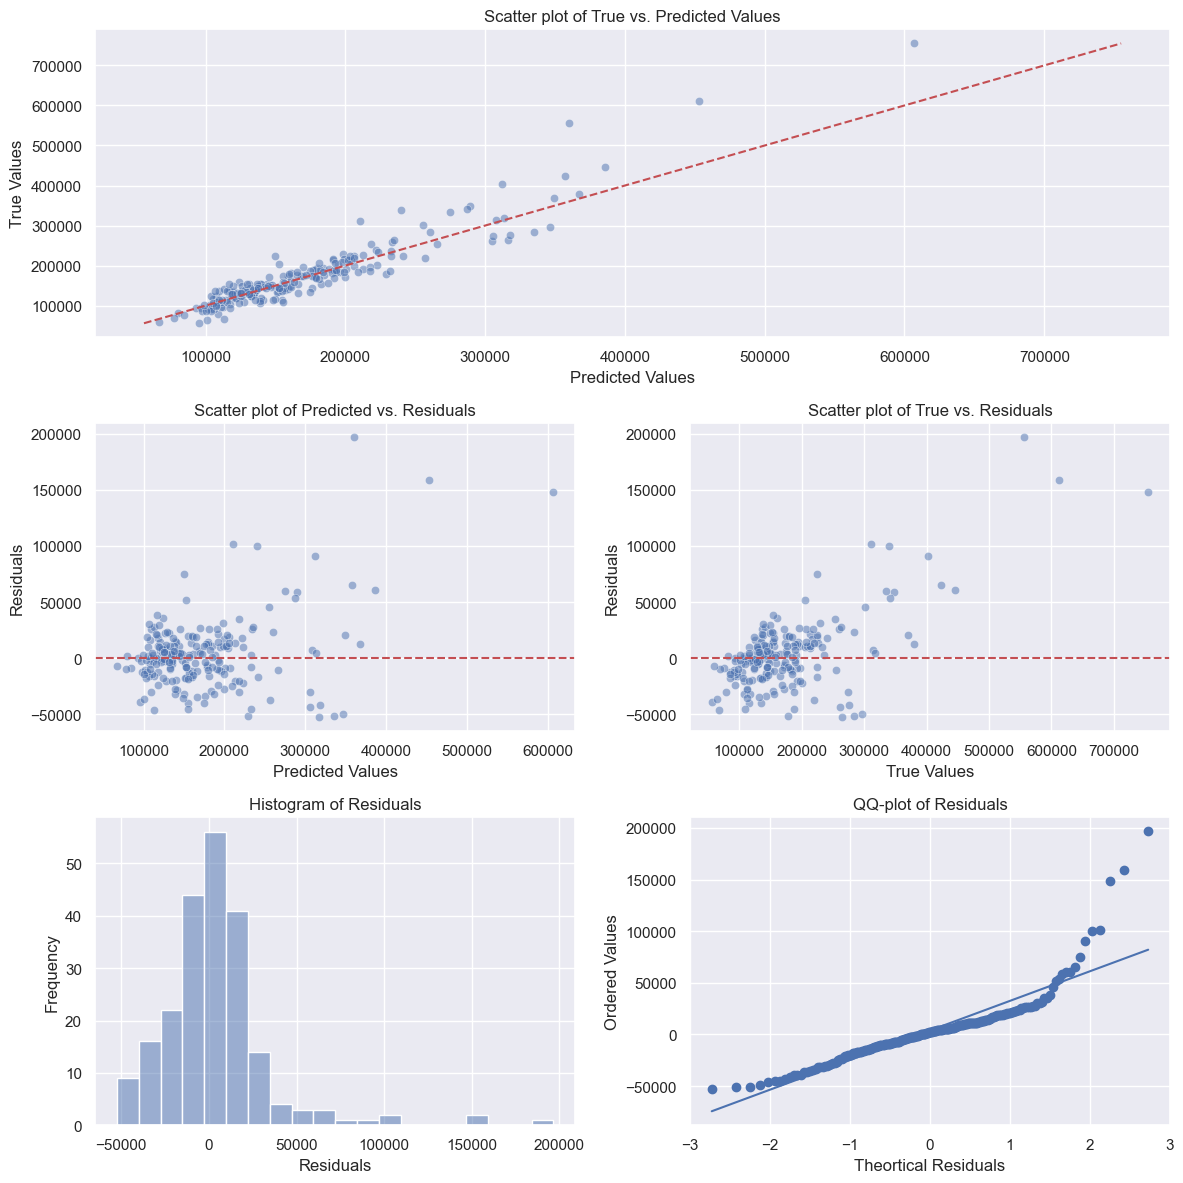

metrics         values
0     MSE 1001570792.470
1     MAE      19984.728
2    RMSE      31647.603
3      R2          0.868

In [74]:
evaluate_regressor(rf_pipeline, X_vald, y_vald)

### XGBoost

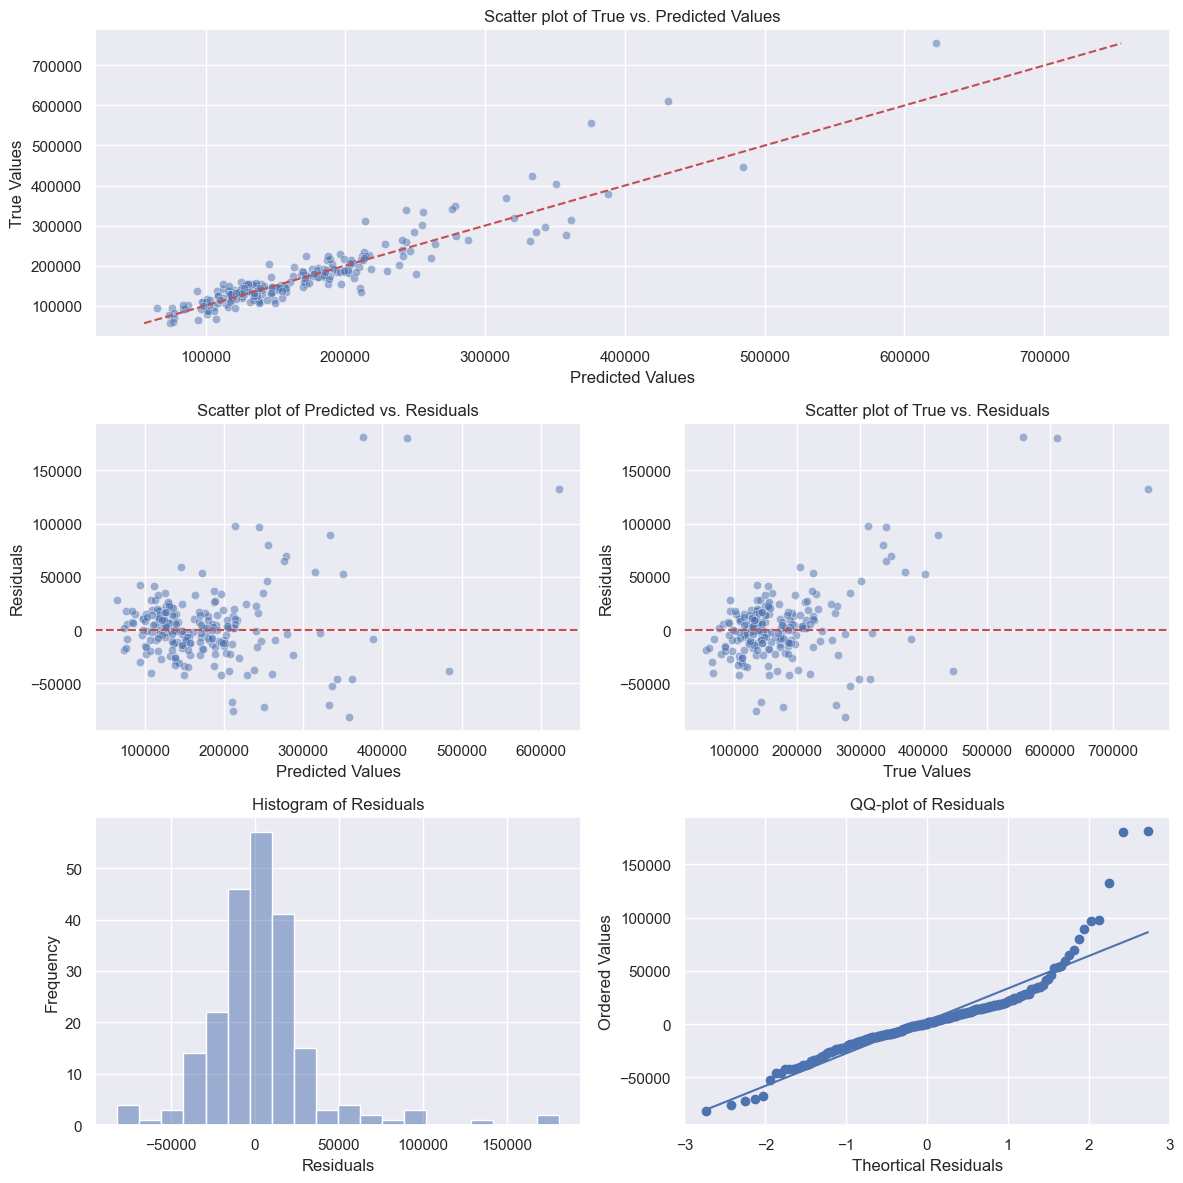

metrics         values
0     MSE 1084391293.891
1     MAE      21070.383
2    RMSE      32930.097
3      R2          0.858

In [75]:
evaluate_regressor(xg_pipeline, X_vald, y_vald)

### lightGBM

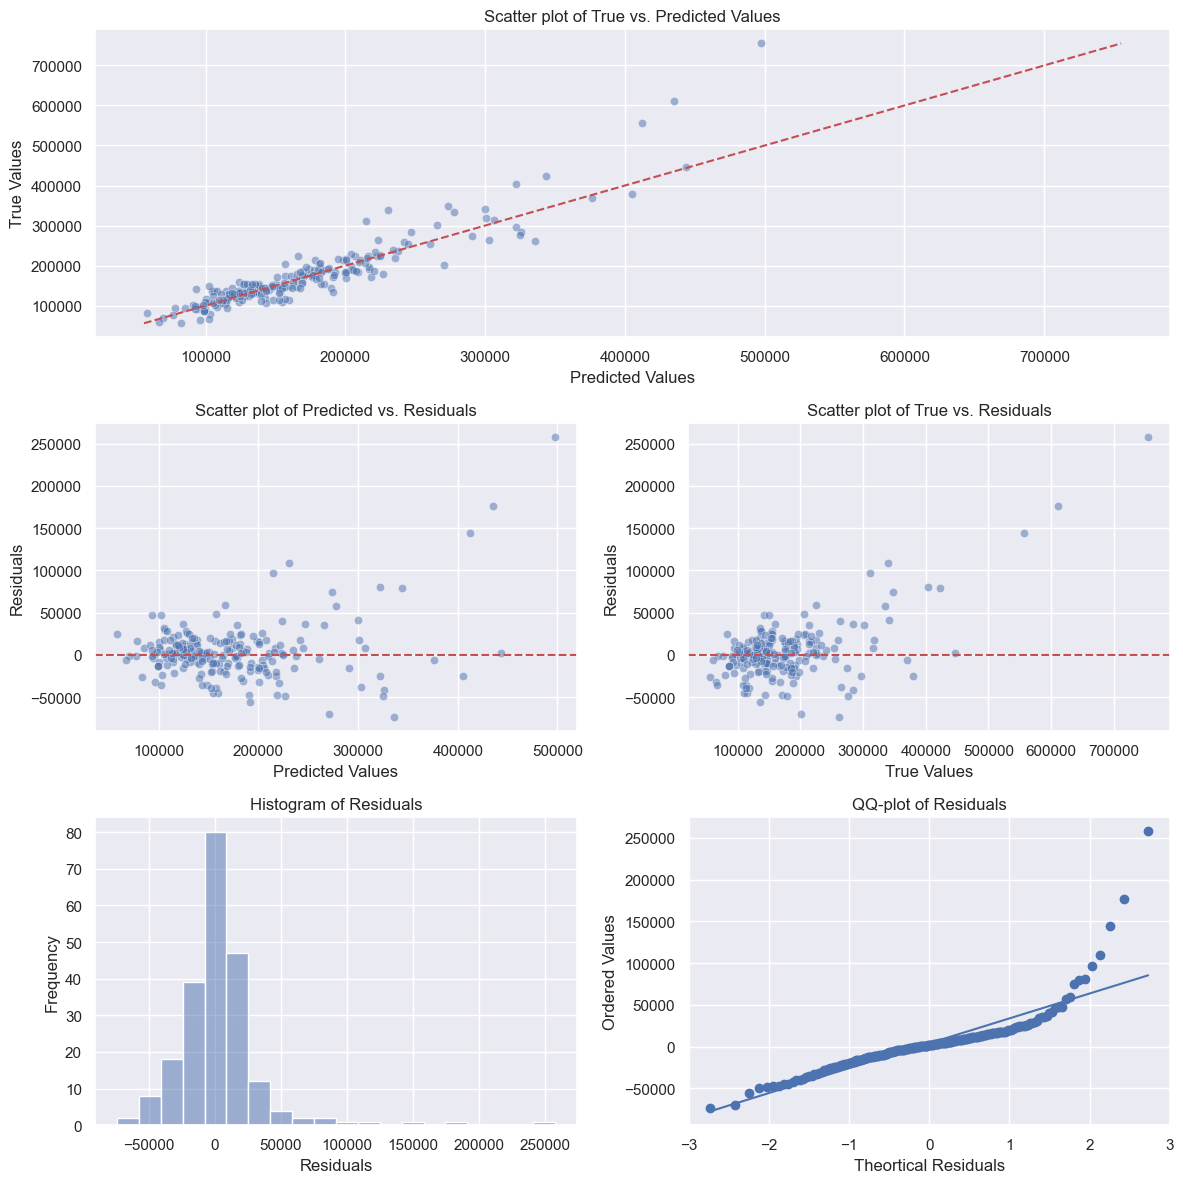

metrics         values
0     MSE 1161307453.246
1     MAE      19959.932
2    RMSE      34077.961
3      R2          0.847

In [76]:
evaluate_regressor(lg_pipeline, X_vald, y_vald)

### Catboost

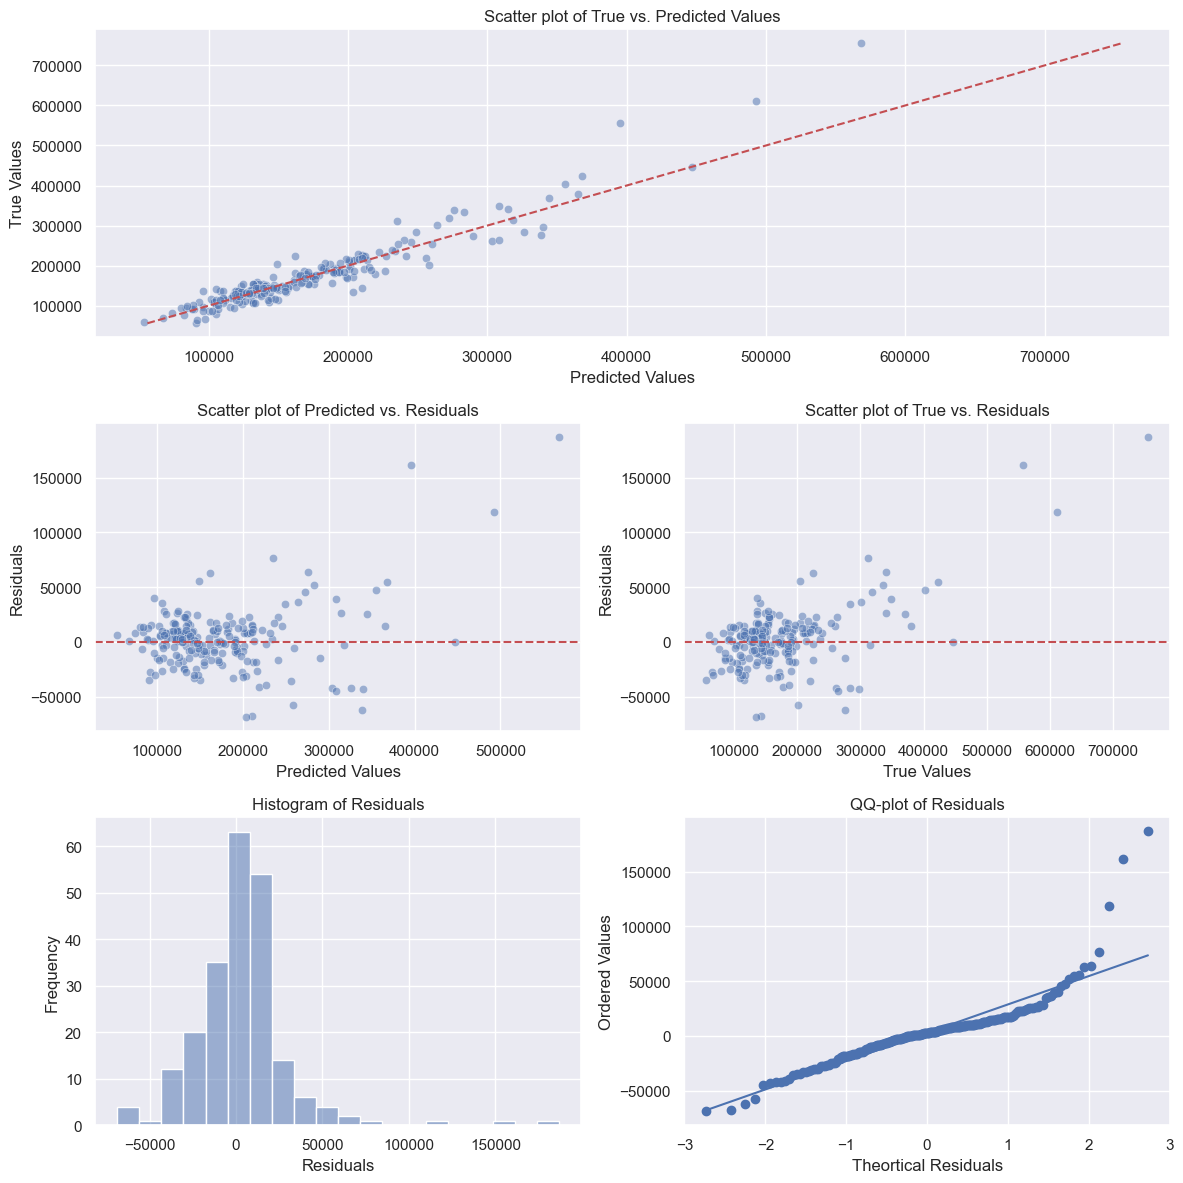

metrics        values
0     MSE 813847560.415
1     MAE     17825.136
2    RMSE     28528.014
3      R2         0.893

In [77]:
evaluate_regressor(cb_pipeline, X_vald, y_vald)

### **Optimization**

We'll go with `CatBoostClassifier`. **WHY?**

*well, glad you asked!*
* The predicted & Real plot shows the least variation around the line.
* The y-axis in the residuals plot didn't shoot to 200000.
* The histogram has the thinnest right tail.
* most points are on the line in the QQ plot.

we will use Optuna for optimization.

In [99]:
def objective(trial):
    
    from sklearn.metrics import mean_squared_error
    param = {
        'loss_function': 'RMSE',
        'task_type': 'GPU',
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.018),
        'n_estimators':  300,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15]),
        'random_state': 42,
    }
    
    model = Pipeline(
    [
        ("transformer", Transformer),
        ("cb", CatBoostRegressor(verbose=0, **param))
    ]
)    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_vald)
    
    rmse = mean_squared_error(y_vald, preds,squared=False)
    
    return rmse

In [101]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-05-31 18:07:26,429] A new study created in memory with name: no-name-ea2c6c4b-1853-42d0-9088-404e52eaf2d4
[I 2023-05-31 18:07:29,200] Trial 0 finished with value: 29984.457411329684 and parameters: {'l2_leaf_reg': 0.018777992998619777, 'max_bin': 261, 'learning_rate': 0.017725715199768878, 'max_depth': 5}. Best is trial 0 with value: 29984.457411329684.
[I 2023-05-31 18:07:31,840] Trial 1 finished with value: 38140.04720901559 and parameters: {'l2_leaf_reg': 0.0076595931950253545, 'max_bin': 204, 'learning_rate': 0.006902180283779796, 'max_depth': 7}. Best is trial 0 with value: 29984.457411329684.
[I 2023-05-31 18:08:18,116] Trial 2 finished with value: 48657.98546480175 and parameters: {'l2_leaf_reg': 9.358675734606772, 'max_bin': 306, 'learning_rate': 0.01599862729071804, 'max_depth': 15}. Best is trial 0 with value: 29984.457411329684.
[I 2023-05-31 18:08:20,904] Trial 3 finished with value: 33403.288923418 and parameters: {'l2_leaf_reg': 0.0018832445209039515, 'max_bin': 3

Number of finished trials: 100
Best trial: {'l2_leaf_reg': 0.06360610999193315, 'max_bin': 265, 'learning_rate': 0.01731936173858758, 'max_depth': 5}


In [103]:
study.best_params

{'l2_leaf_reg': 0.06360610999193315,
 'max_bin': 265,
 'learning_rate': 0.01731936173858758,
 'max_depth': 5}

In [108]:
model = Pipeline(
    [
        ("transformer", Transformer),
        ("cb", CatBoostRegressor(verbose=0, l2_leaf_reg=0.0636, max_bin=265, learning_rate=0.017, max_depth=5)) # writing the best hyperparameters
    ]
)  

In [109]:
model.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['OverallQual'],
                                            [SimpleImputer(strategy='median'),
                                             MinMaxScaler()],
                                            {}),
                                           (['GarageCars'],
                                            [SimpleImputer(strategy='median'),
                                             MinMaxScaler()],
                                            {}),
                                           (['TotalBsmtSF'],
                                            [SimpleImputer(strategy='median'),
                                             MinMaxScaler()],
                                            {}),
                                           (['MasVnrArea'],
                                            [SimpleImputer(strategy='median'),
                                             MinMax...
                                             OrdinalEncoder()],
                                            {}),
                                           (['BsmtFinType1'],
                                            [SimpleImputer(strategy='most_frequent'),
                                             OrdinalEncoder()],
                                            {}),
                                           (['Neighborhood'],
                                            [SimpleImputer(strategy='most_frequent'),
                                             OrdinalEncoder()],
                                            {}),
                                           (['BsmtExposure'],
                                            [SimpleImputer(strategy='most_frequent'),
                                             OrdinalEncoder()],
                                            {})],
                                 input_df=True)),
                ('cb',
                 <catboost.core.CatBoostRegressor object at 0x000001EC50049600>)])

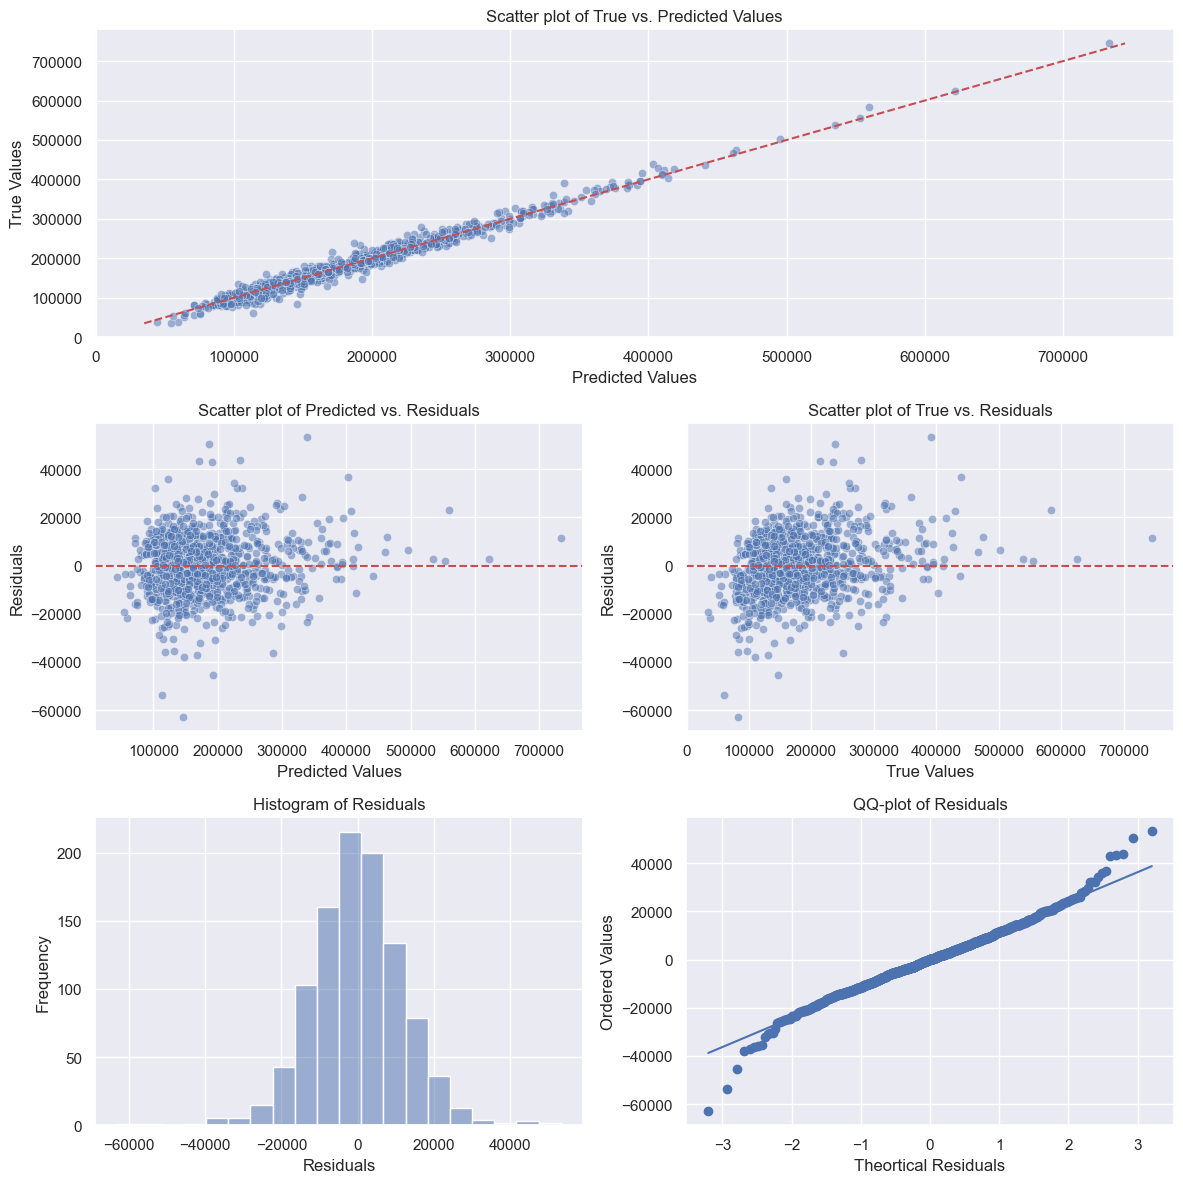

metrics        values
0     MSE 148246250.675
1     MAE      9266.092
2    RMSE     12175.642
3      R2         0.975

In [125]:
evaluate_regressor(model, X_train, y_train)

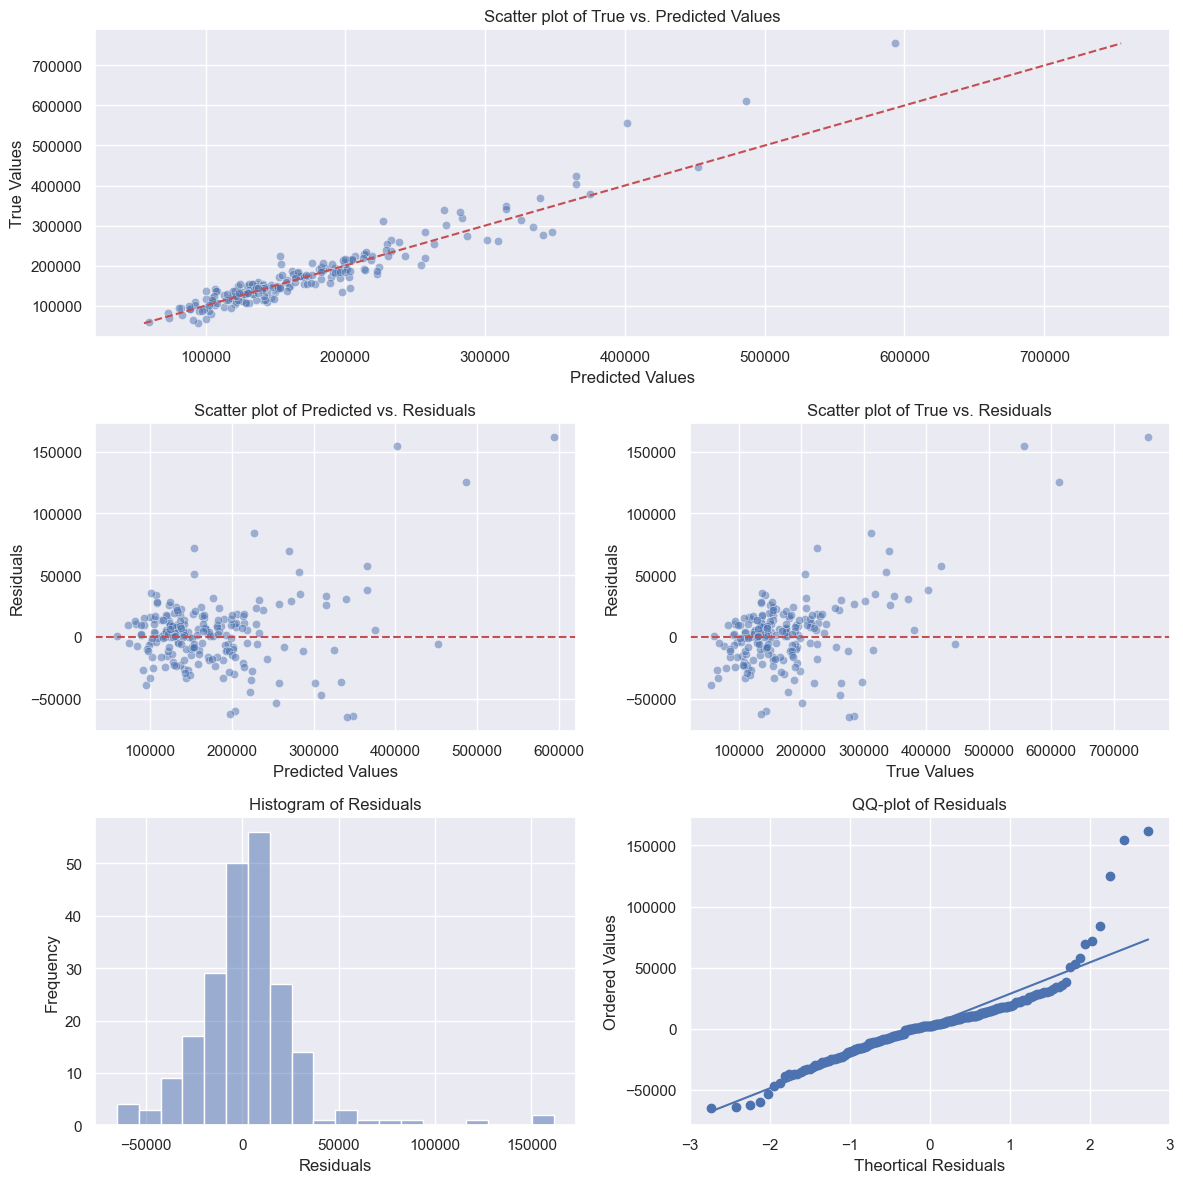

metrics        values
0     MSE 781073258.698
1     MAE     17992.008
2    RMSE     27947.688
3      R2         0.897

In [126]:
evaluate_regressor(model, X_vald, y_vald)

### **Testing**

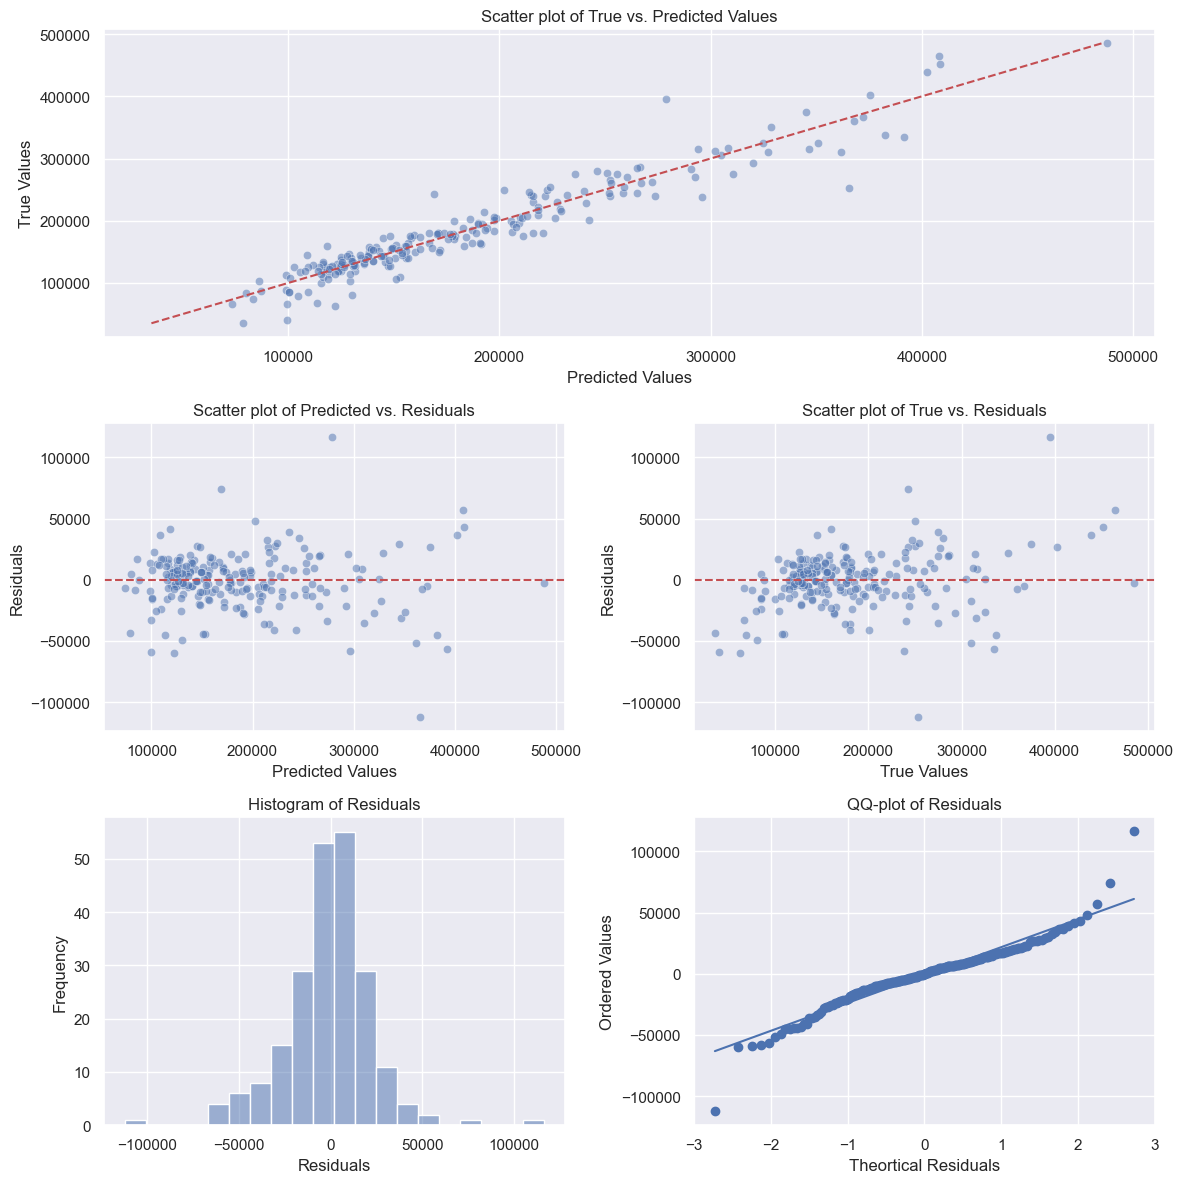

metrics        values
0     MSE 548944127.089
1     MAE     16471.250
2    RMSE     23429.557
3      R2         0.913

In [127]:
evaluate_regressor(model, X_test, y_test)

Great Results!

### **Submitting To Kaggle**

In [115]:
housing_test = pd.read_csv("house-prices-advanced-regression-techniques/test.csv")
housing_test

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0     1461          20       RH       80.000    11622   Pave   NaN      Reg   
1     1462          20       RL       81.000    14267   Pave   NaN      IR1   
2     1463          60       RL       74.000    13830   Pave   NaN      IR1   
3     1464          60       RL       78.000     9978   Pave   NaN      IR1   
4     1465         120       RL       43.000     5005   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1454  2915         160       RM       21.000     1936   Pave   NaN      Reg   
1455  2916         160       RM       21.000     1894   Pave   NaN      Reg   
1456  2917          20       RL      160.000    20000   Pave   NaN      Reg   
1457  2918          85       RL       62.000    10441   Pave   NaN      Reg   
1458  2919          60       RL       74.000     9627   Pave   NaN      Reg   

     LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence  \
0            Lvl    AllPub  ...         120        0    NaN  MnPrv   
1            Lvl    AllPub  ...           0        0    NaN    NaN   
2            Lvl    AllPub  ...           0        0    NaN  MnPrv   
3            Lvl    AllPub  ...           0        0    NaN    NaN   
4            HLS    AllPub  ...         144        0    NaN    NaN   
...          ...       ...  ...         ...      ...    ...    ...   
1454         Lvl    AllPub  ...           0        0    NaN    NaN   
1455         Lvl    AllPub  ...           0        0    NaN    NaN   
1456         Lvl    AllPub  ...           0        0    NaN    NaN   
1457         Lvl    AllPub  ...           0        0    NaN  MnPrv   
1458         Lvl    AllPub  ...           0        0    NaN    NaN   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
0            NaN       0      6    2010        WD         Normal  
1           Gar2   12500      6    2010        WD         Normal  
2            NaN       0      3    2010        WD         Normal  
3            NaN       0      6    2010        WD         Normal  
4            NaN       0      1    2010        WD         Normal  
...          ...     ...    ...     ...       ...            ...  
1454         NaN       0      6    2006        WD         Normal  
1455         NaN       0      4    2006        WD        Abnorml  
1456         NaN       0      9    2006        WD        Abnorml  
1457        Shed     700      7    2006        WD         Normal  
1458         NaN       0     11    2006        WD         Normal  

[1459 rows x 80 columns]

In [123]:
# Creating a csv file.
predictions = model.predict(housing_test)
ids = housing_test["Id"]

df = pd.DataFrame({"Id": ids, "SalePrice": predictions})
df.to_csv("SuperMaker_submission.csv", index=False)

## **Summary**

### In this kernel:
* Imported the data.
* Inspected the data.
* Handled Null values.
* Performed Feature selection with CFS, ANOVA.
* Splitted Our data - Training, Validation, Testing.
* Built Pipelines with DataFrameMapper.
* Created & Compared different models.
* Tuned The Hyperparameters of our selected model.
* Performed Testing.

This project was a great one. Hope you like it!